<a href="https://colab.research.google.com/github/wanyuL/ReinforcementRats2021/blob/master/RNN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run rnn0 on fake data

In [1]:
%load_ext autoreload
%autoreload 2

# Colab:
# ! git clone https://github.com/wanyuL/ReinforcementRats2021.git 
# import sys 
# sys.path.append('./ReinforcementRats2021')

In [2]:
import nmastandard
from rnn0 import *
from gen_fake_data import *
from load_data import *
import pickle

In [3]:
device=nmastandard.set_device()  # select device



In [10]:
# prepare for training

# file = open("Cori_MOs.pkl",'rb')
file = open("Cori_Post.pkl",'rb')
spk = pickle.load(file)

NT=spk.shape[0]
ntrials=spk.shape[1]
NN=spk.shape[2]
ncomp=10

import nmastandard as nmas
SEED = 2021
nmas.set_seed(seed=SEED)
idx_selection = np.random.choice(spk.shape[1], size=spk.shape[1])

trainidx = idx_selection[:ntrials*3//5]
validx = idx_selection[ntrials*3//5:ntrials*4//5]
testidx = idx_selection[ntrials*4//5:]


file = open("Cori_Post_trainidx.pkl",'wb')
pickle.dump(trainidx, file)
file = open("Cori_Post_validx.pkl",'wb')
pickle.dump(validx, file)
file = open("Cori_Post_testidx.pkl",'wb')
pickle.dump(testidx, file)



file = open("Cori_Post_trainidx.pkl",'rb')
trainidx = pickle.load(file)
file = open("Cori_Post_trainidx.pkl",'rb')
validx = pickle.load(file)
file = open("Cori_Post_trainidx.pkl",'rb')
testidx = pickle.load(file)

trainDat = spk[:, trainidx, :].copy()
valDat = spk[:, validx, :].copy()
testDat = spk[:, testidx, :].copy()

# resp_train = resp[trainidx]
# resp_val = resp[validx]
# resp_test = resp[testidx]





trainingData = torch.from_numpy(trainDat).to(device).float()
testData = torch.from_numpy(valDat).to(device).float()


Random seed 2021 has been set.


In [11]:
trainingData.shape

torch.Size([250, 150, 254])

In [12]:
import rnnautoencoder as rnnae


In [13]:
#NN1 = trainingData.shape[-1]
#NN2 = testData.shape[-1]

# we initialize the neural network
# net = rnn0(ncomp, trainingData.shape[-1], trainingData.shape[-1], dropout=0.5 ,bidi = False).to(device)
net = rnnae.RNNAE(trainingData.shape[-1], 50, [100, 75], [75, 100])

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
# net.fc.bias.data[:] = trainingData.mean((0,1))


In [14]:
# train the rnn!

import nmastandard as nmas
SEED = 2021
nmas.set_seed(seed=SEED)
DEVICE = nmas.set_device()

print(f'Naive 0 Guess Accuracy: {1-(testData > 0).float().mean()}')

loss, val_loss = rnnae.train_autoencoder(net, trainingData, DEVICE, val_dataset=testData, epochs=51, batch_size=10, seed=0)
# might not expect the model to generalize well, as the adjacency matrices might 
# differ between different neuron subpopulations

plt.figure()
plt.title('Loss Curves')
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()

Random seed 2021 has been set.
Naive 0 Guess Accuracy: 0.9667339324951172


MSE Train @ 0: Loss — 0.04040084034204483, Acc — 0.8786048293113708
	Val @ 0: Loss — 0.04040084034204483, Acc — 0.8786048293113708


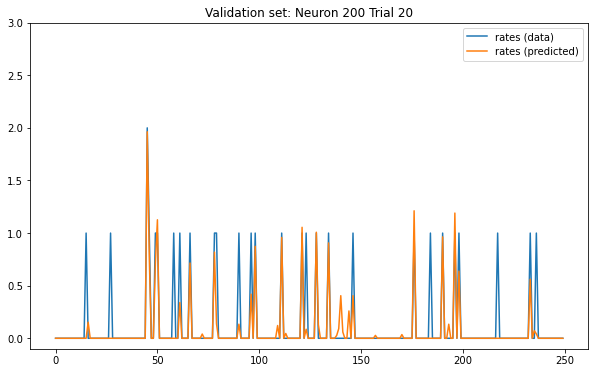

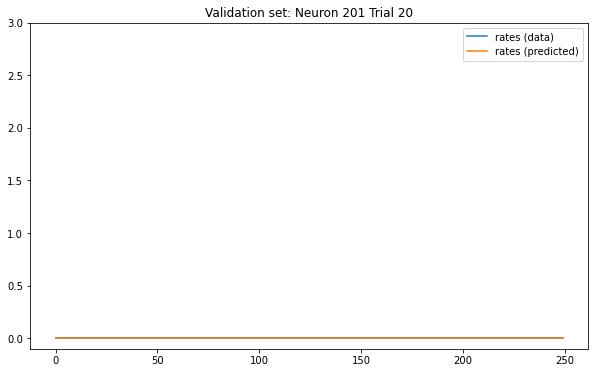

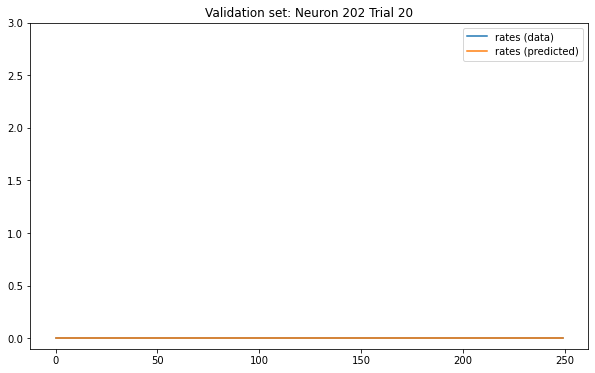

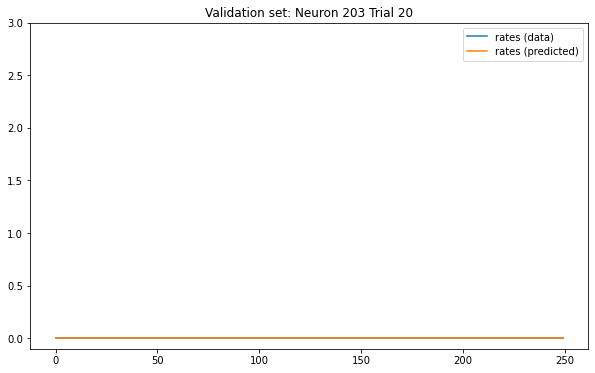

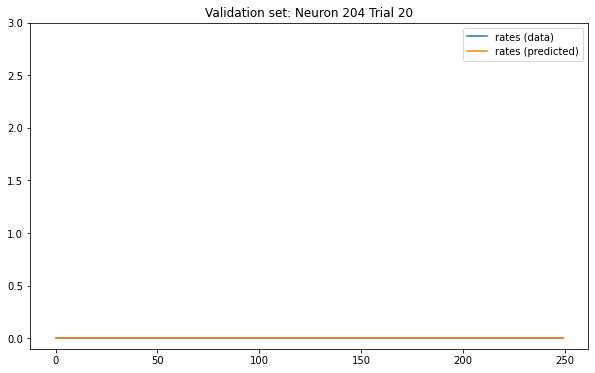

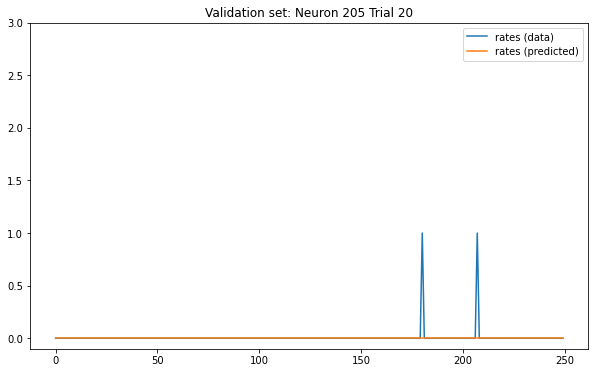

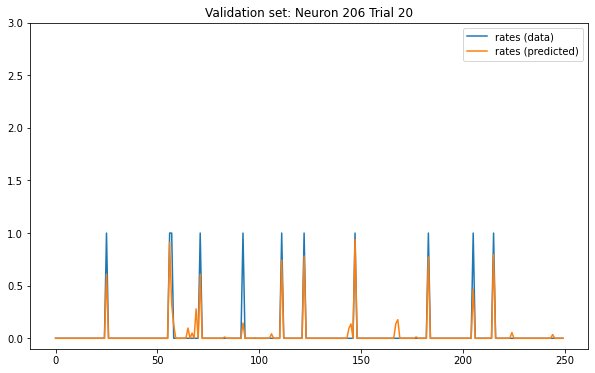

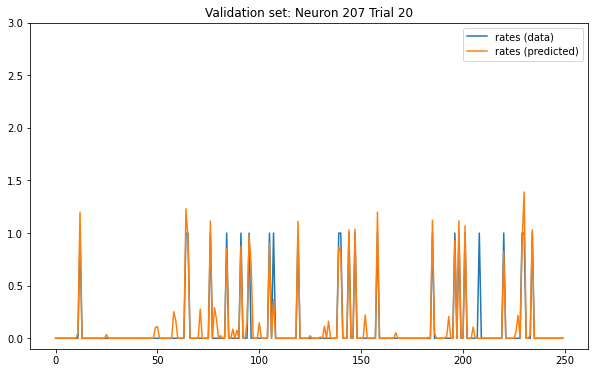

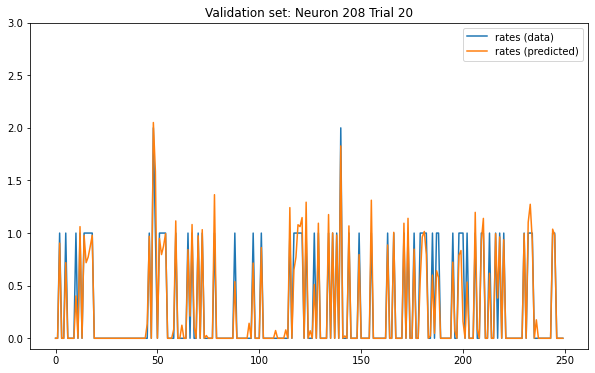

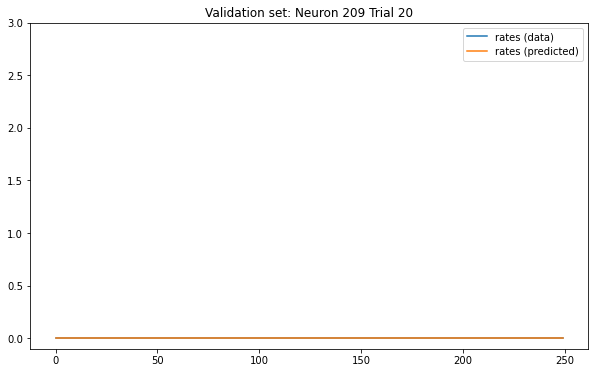

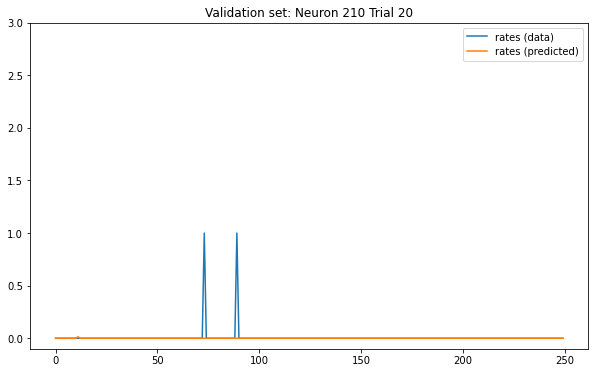

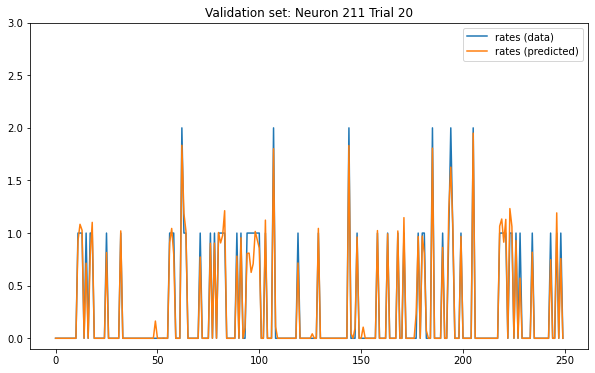

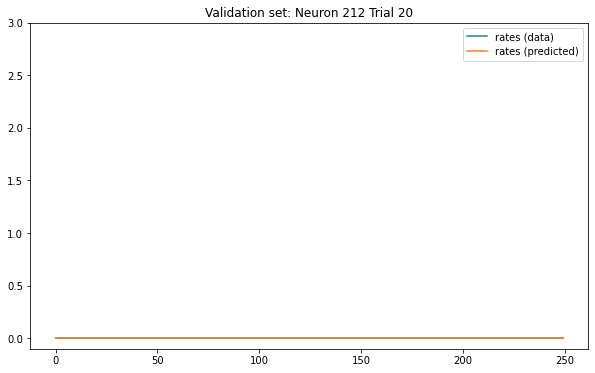

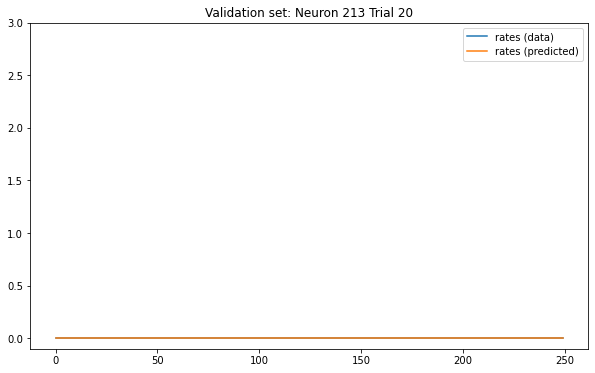

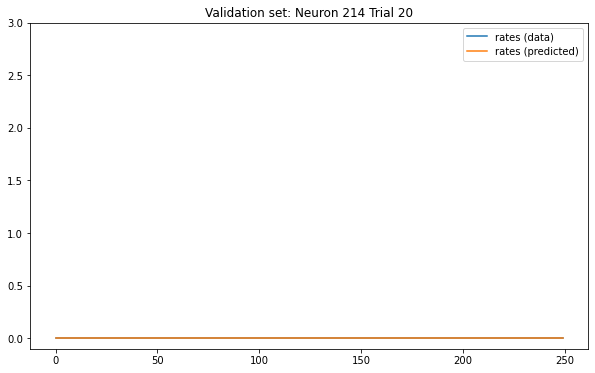

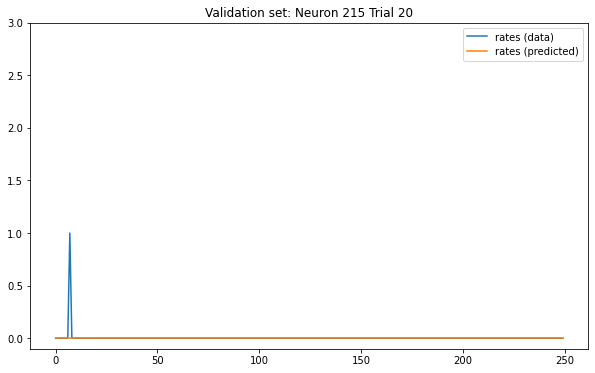

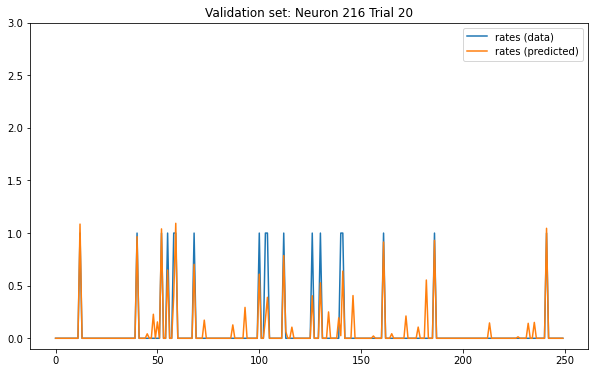

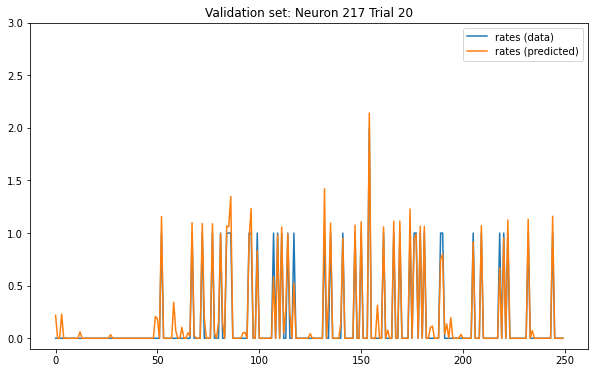

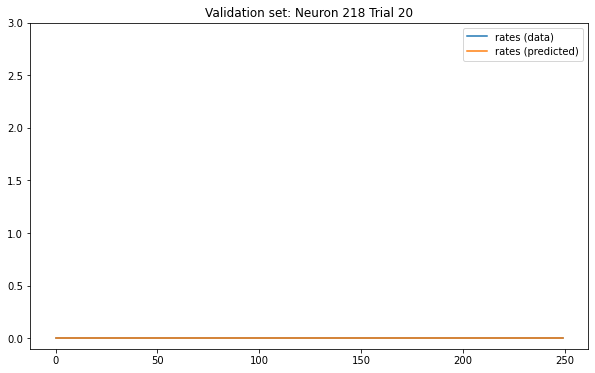

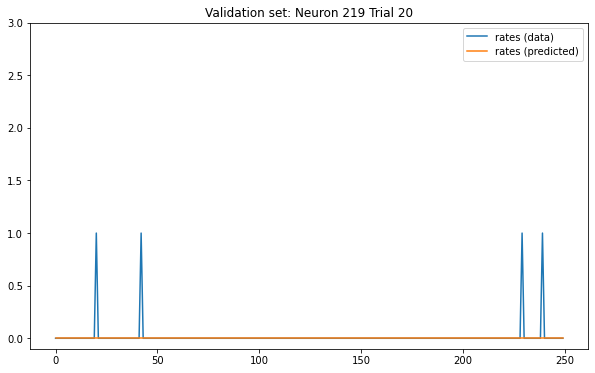

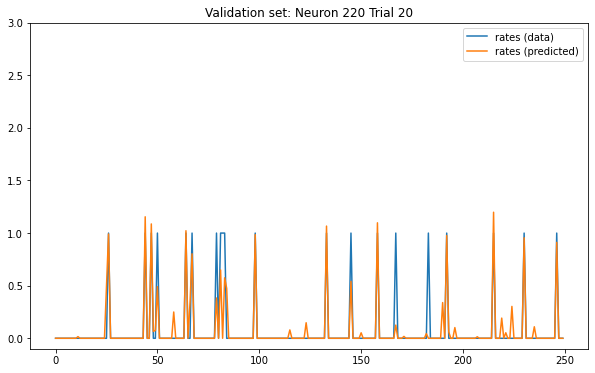

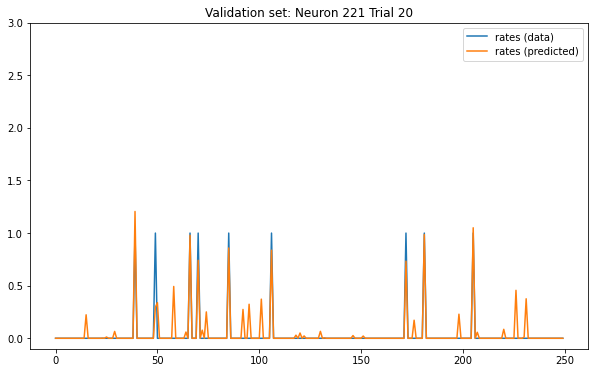

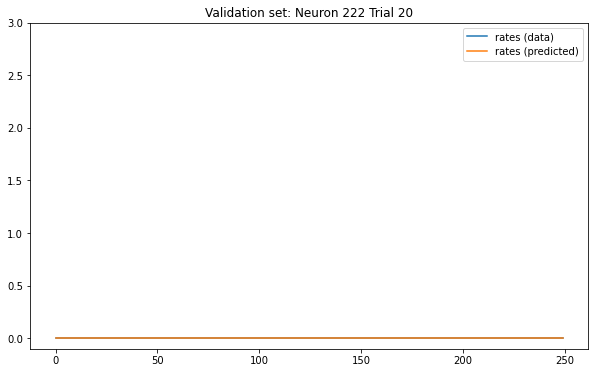

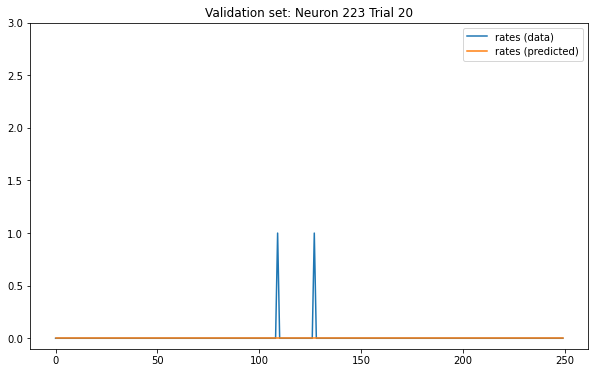

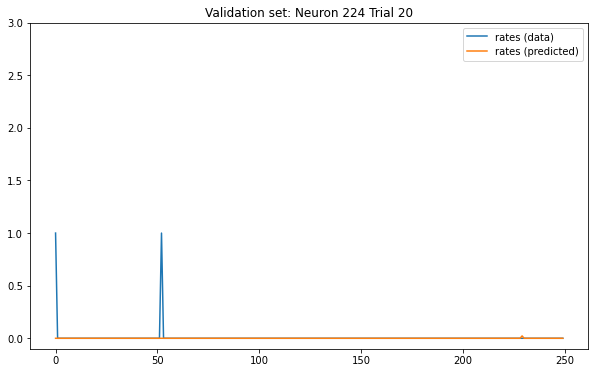

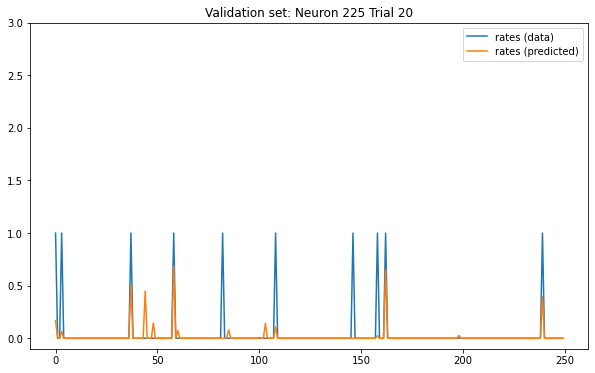

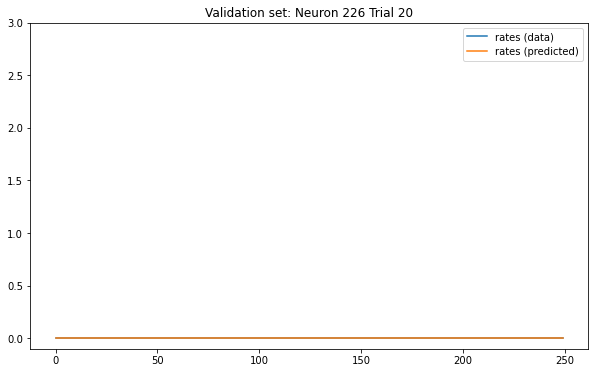

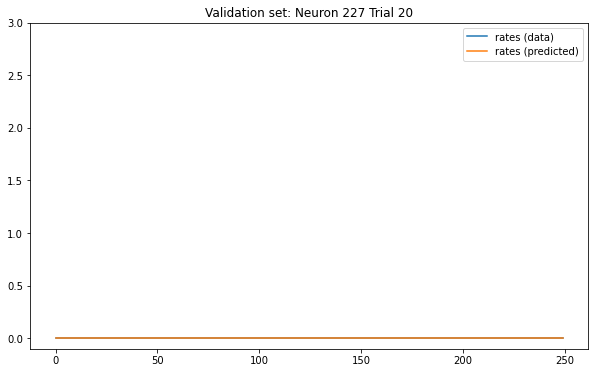

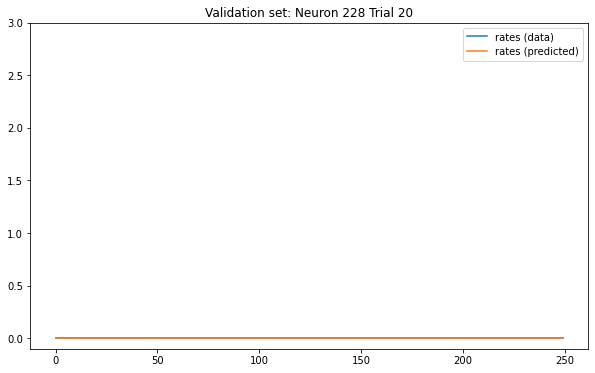

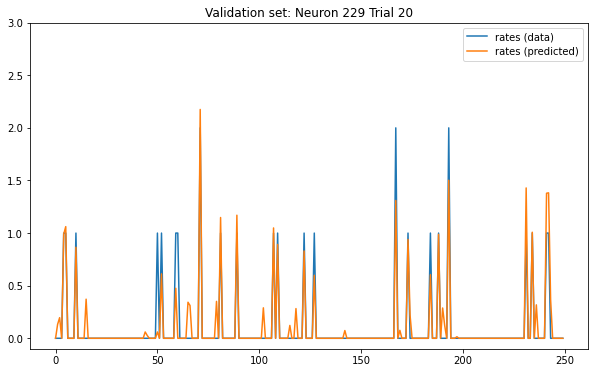

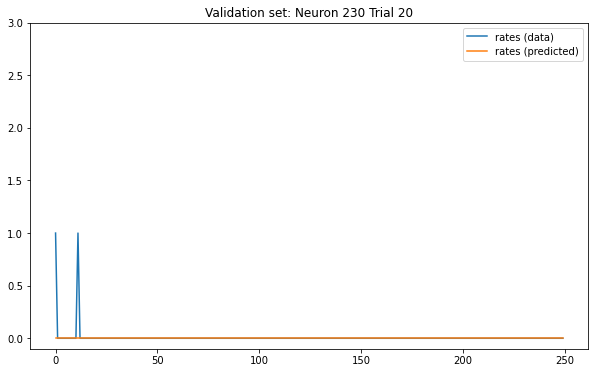

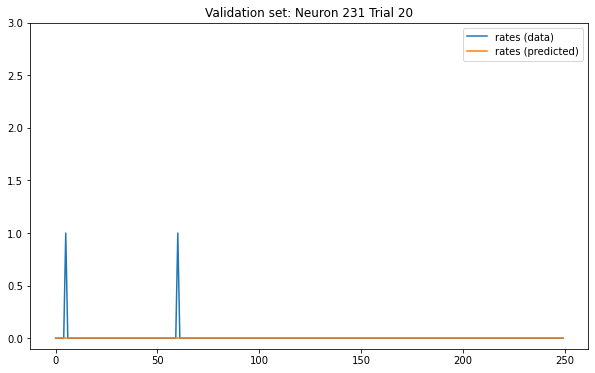

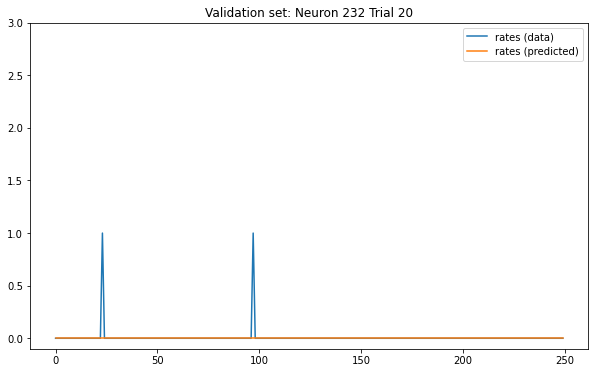

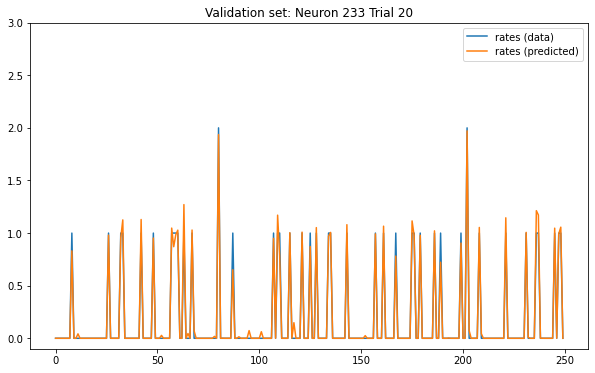

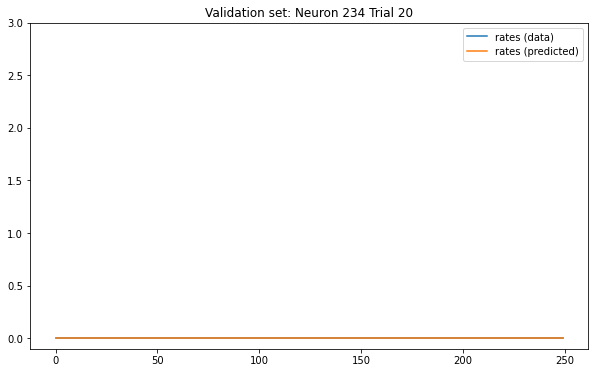

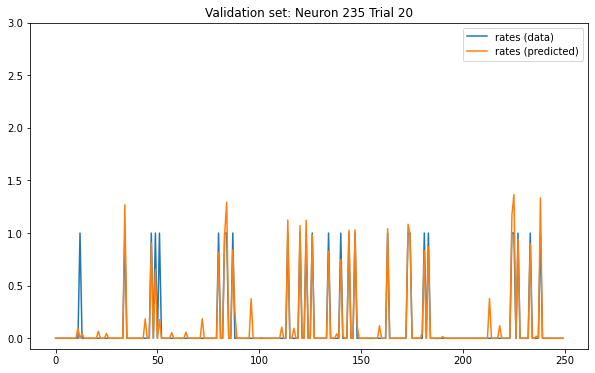

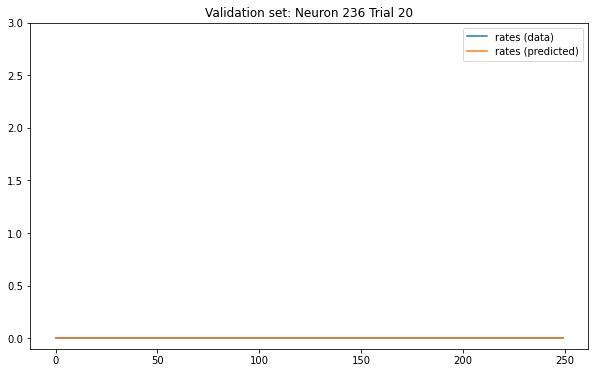

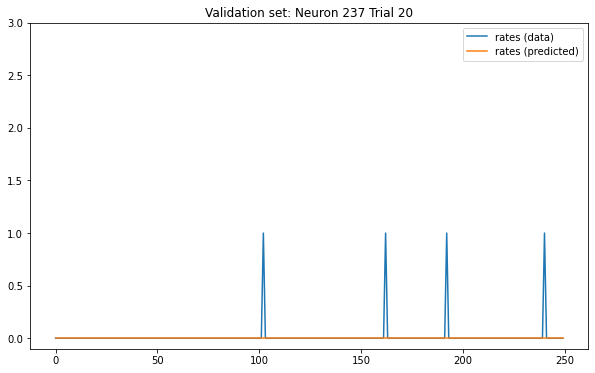

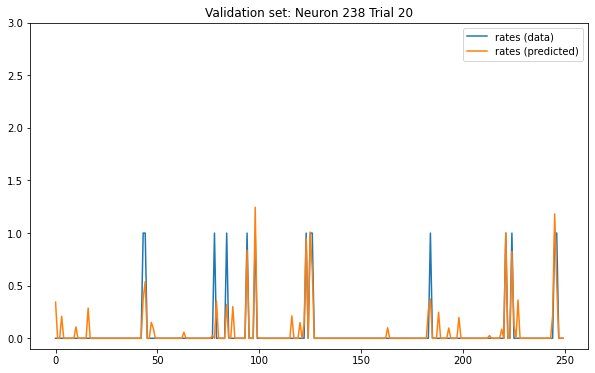

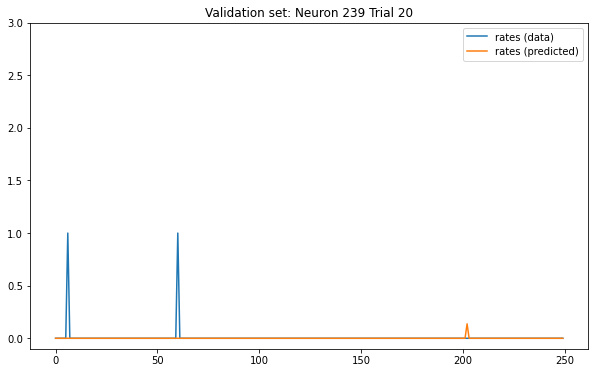

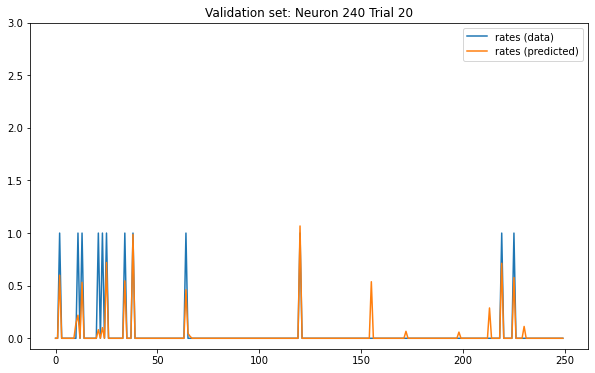

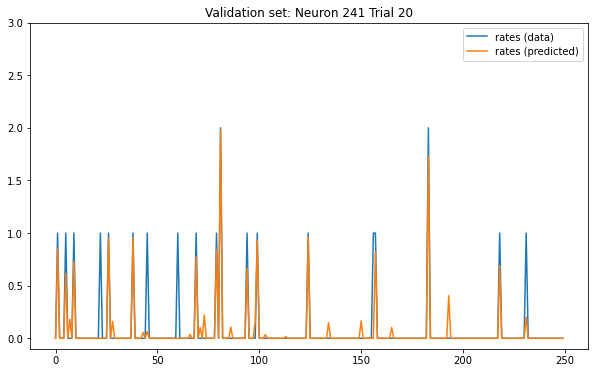

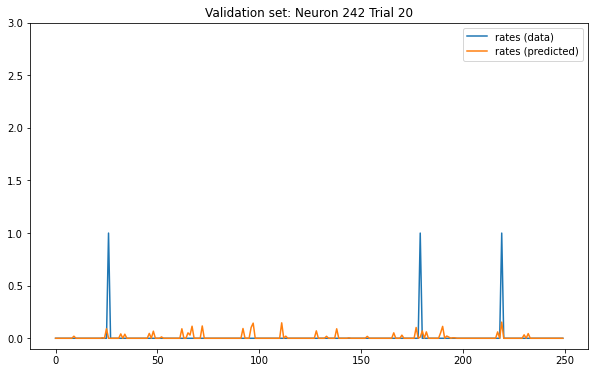

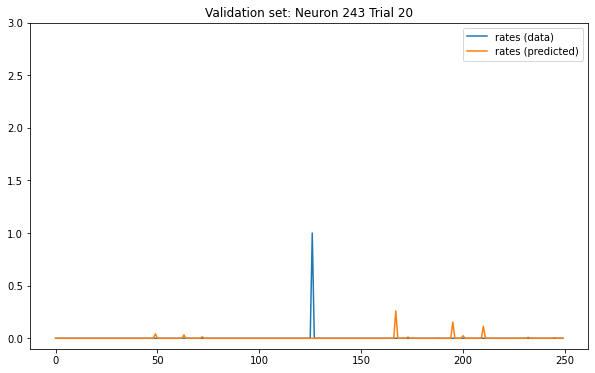

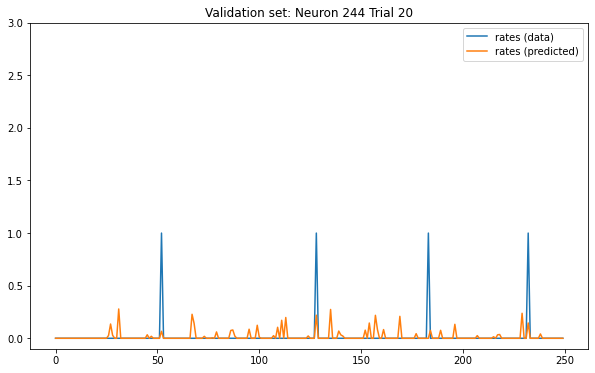

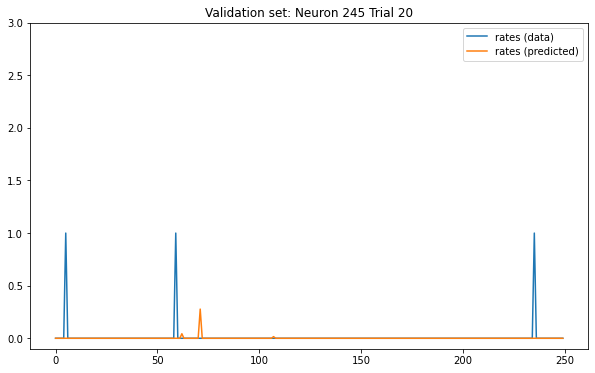

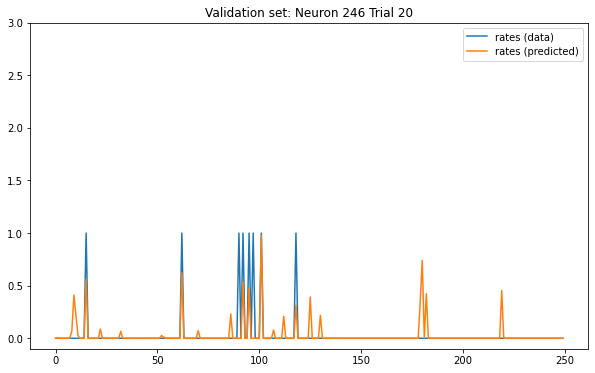

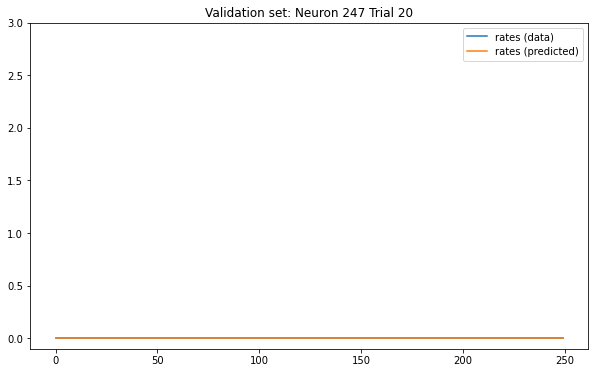

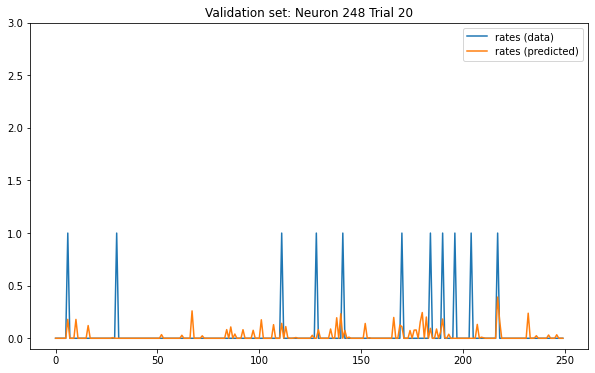

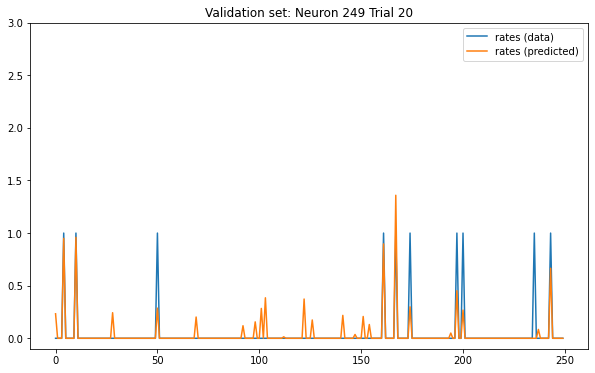

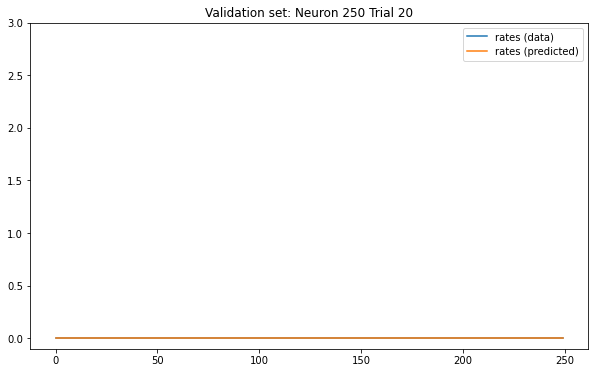

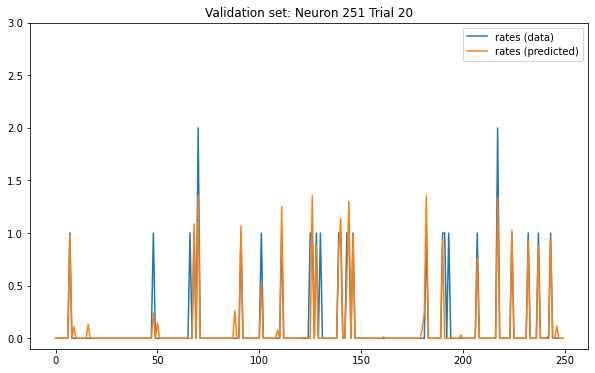

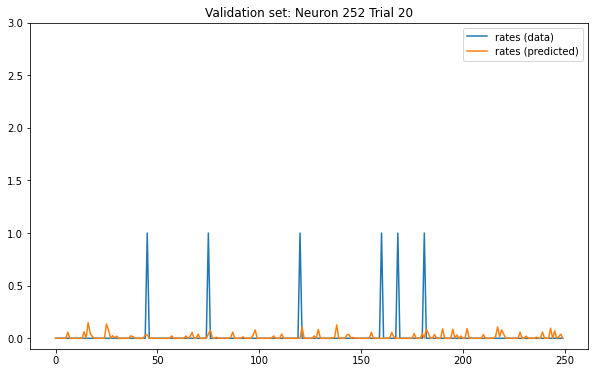

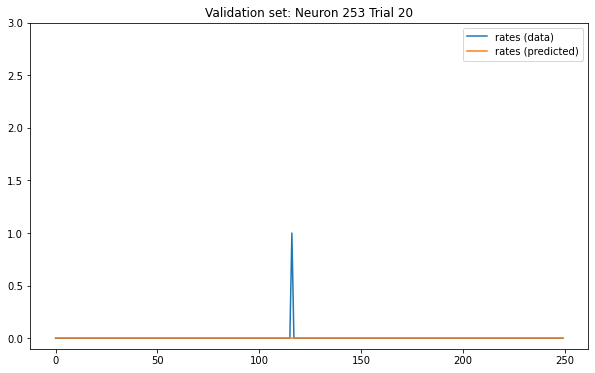

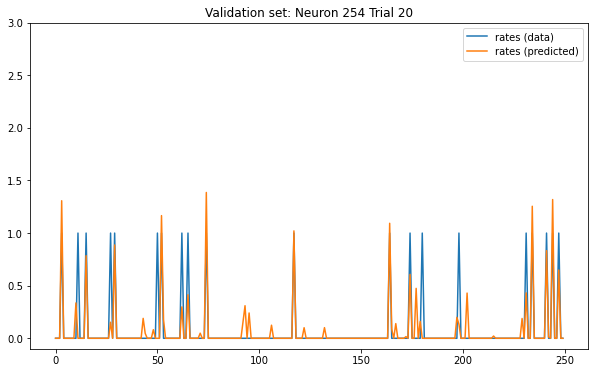

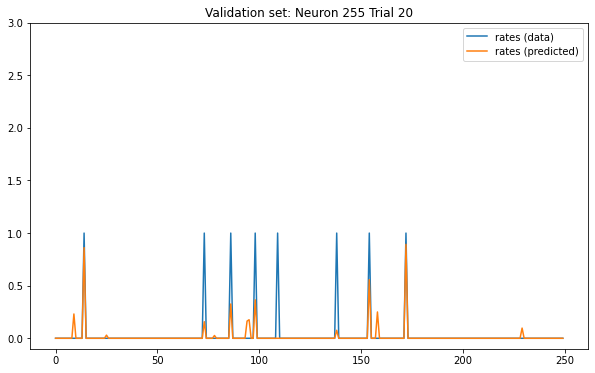

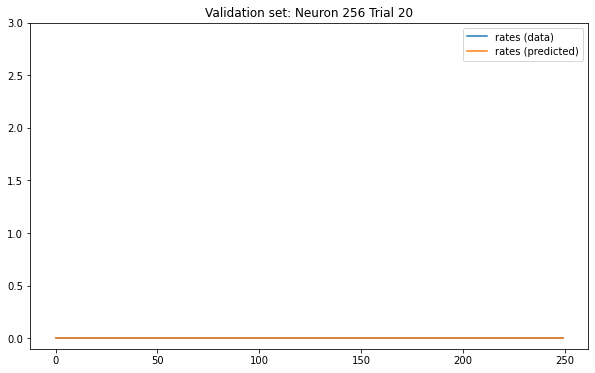

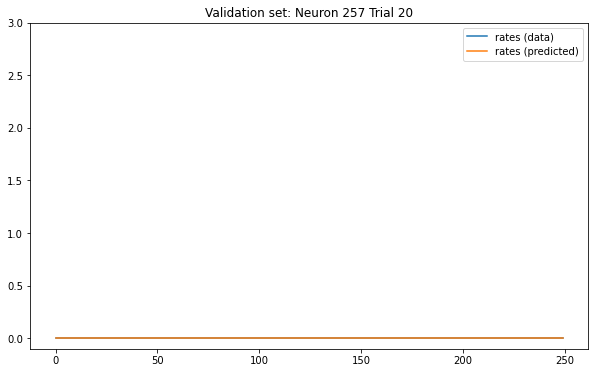

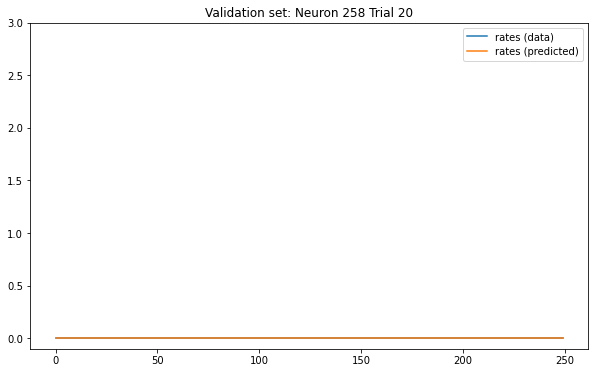

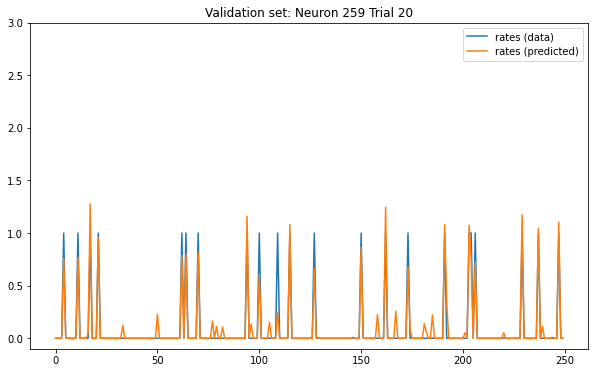

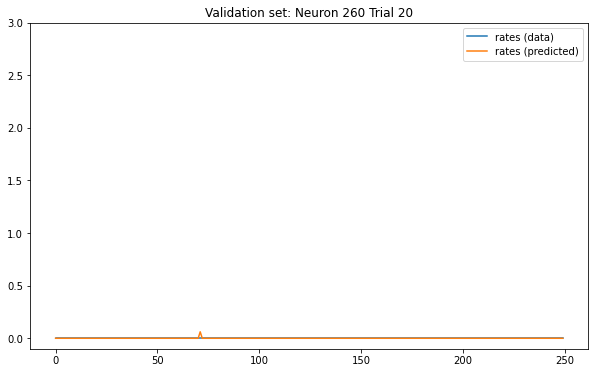

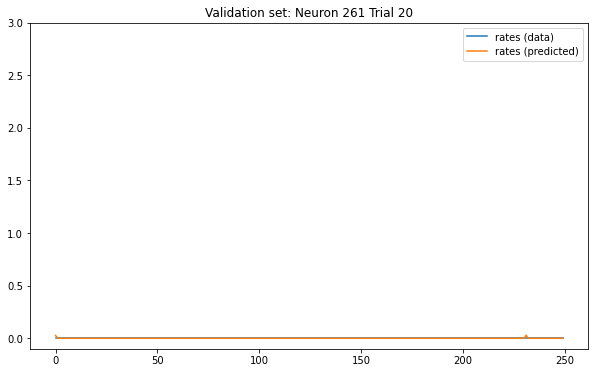

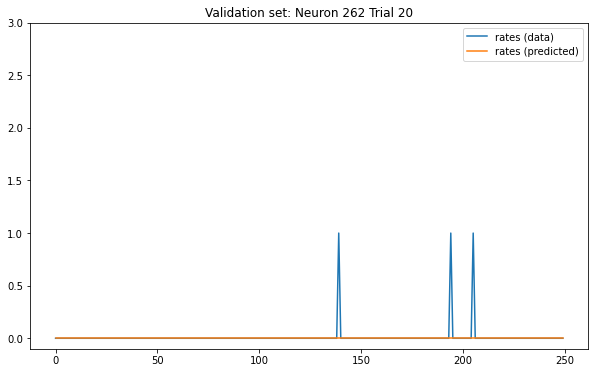

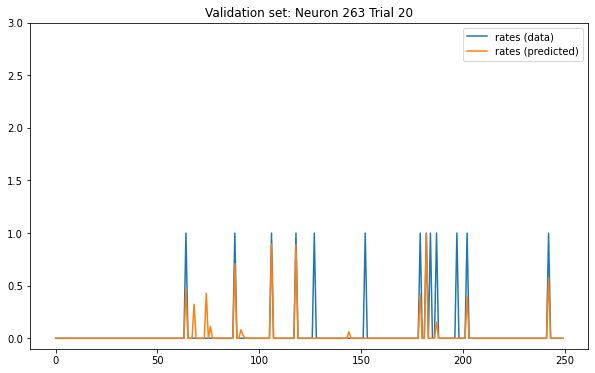

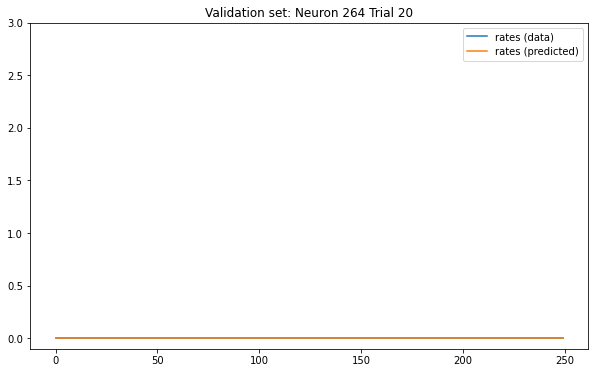

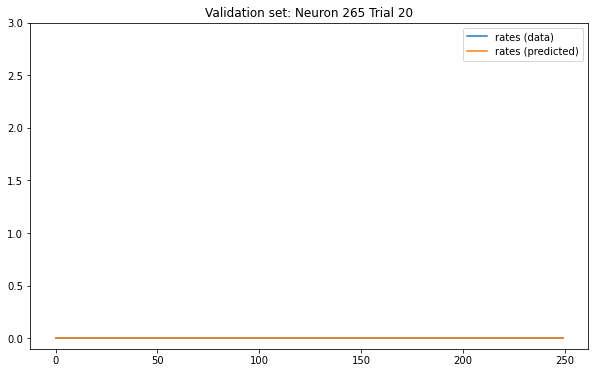

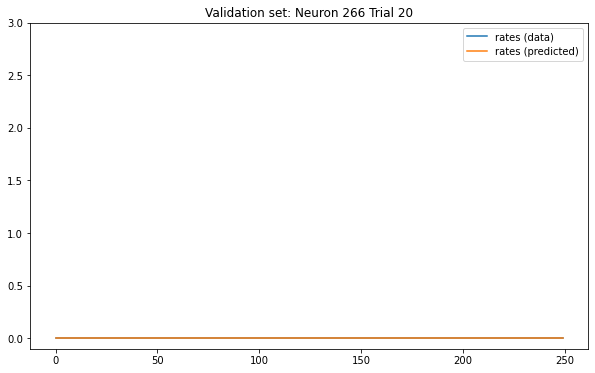

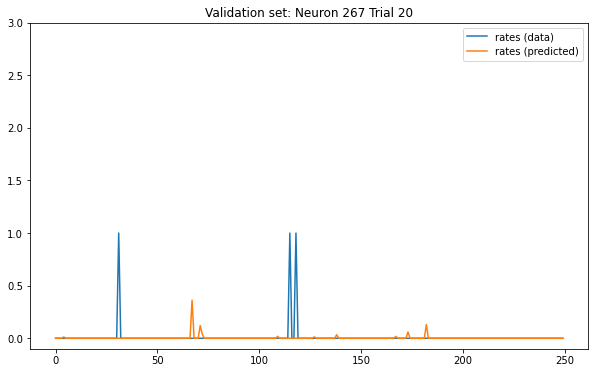

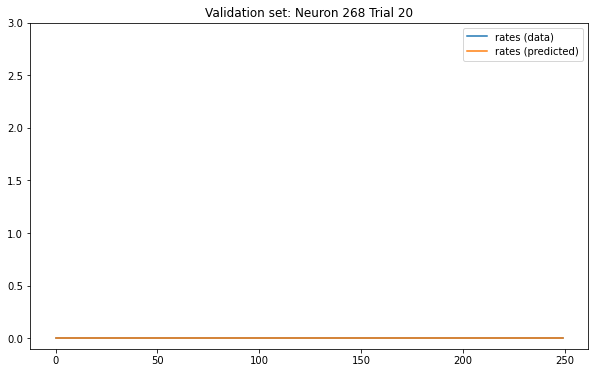

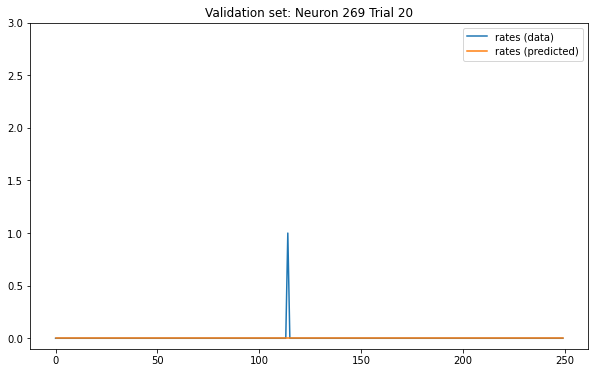

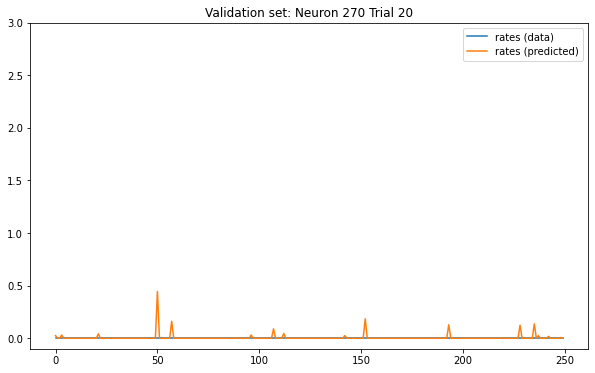

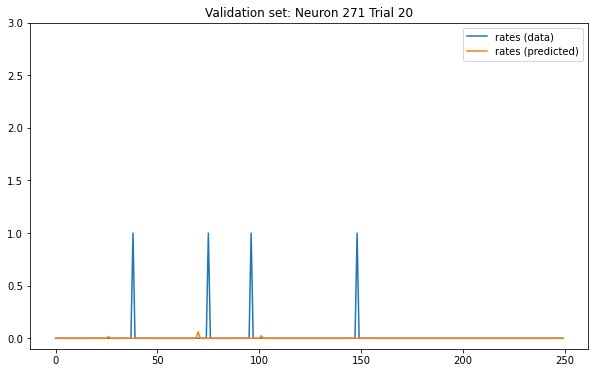

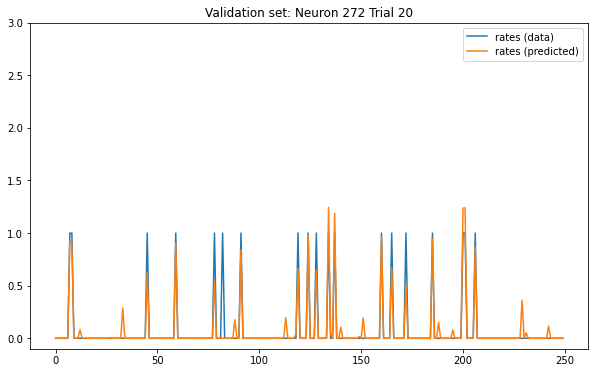

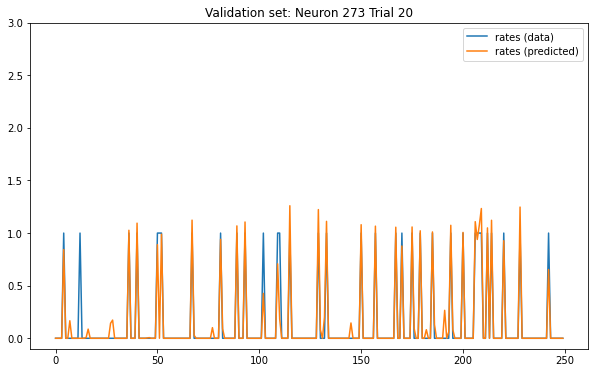

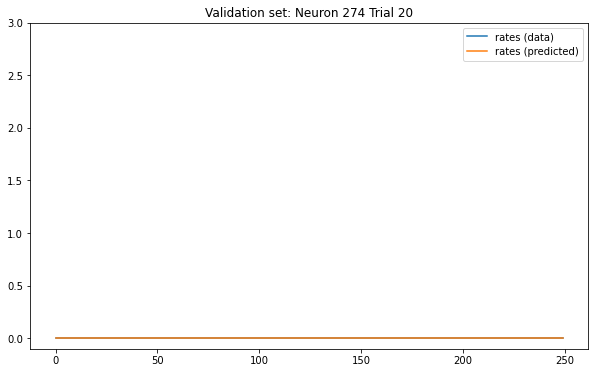

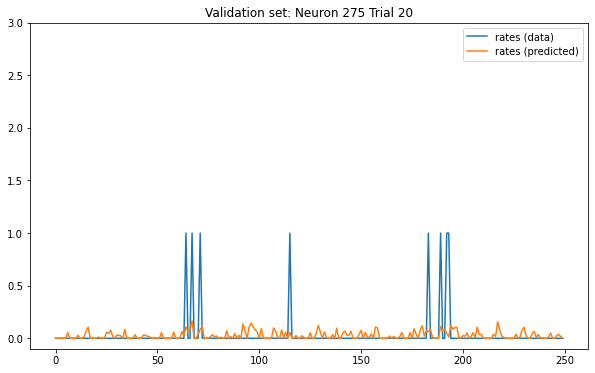

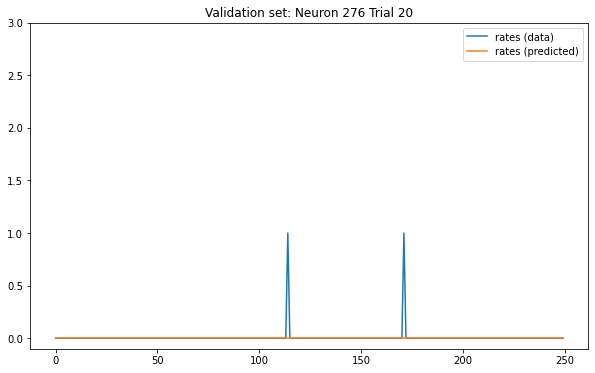

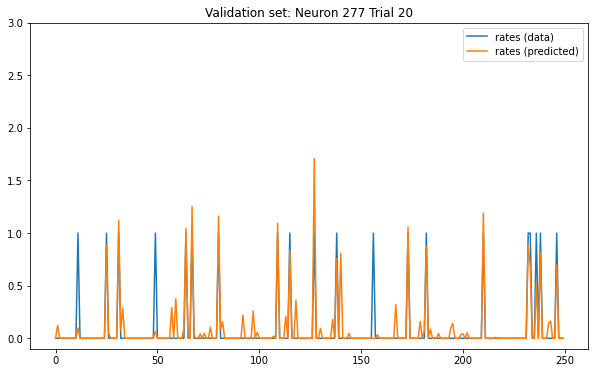

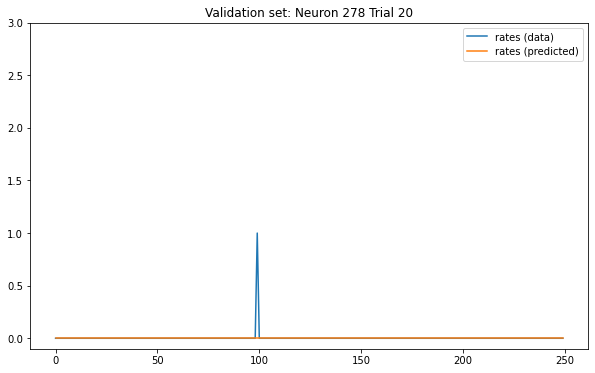

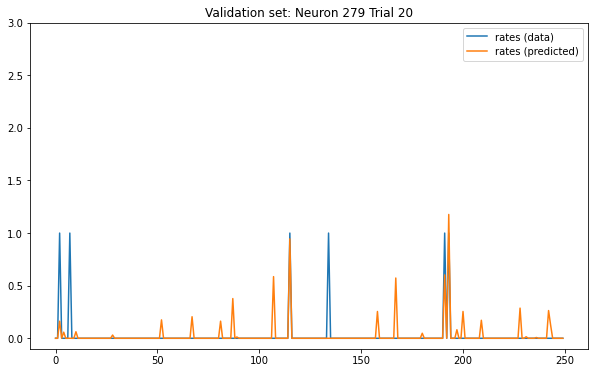

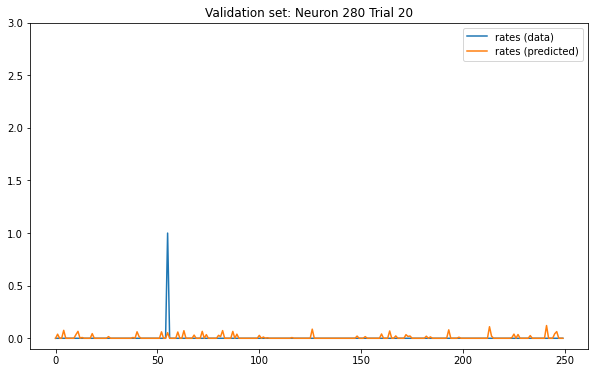

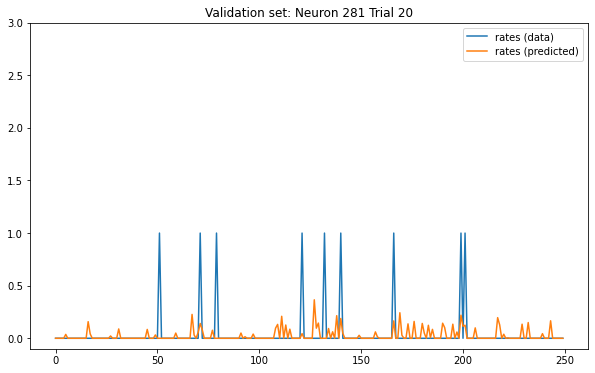

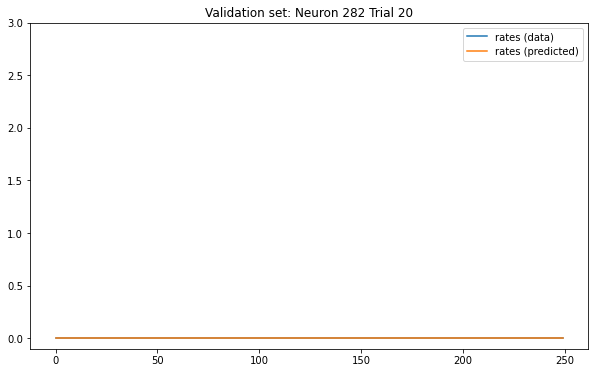

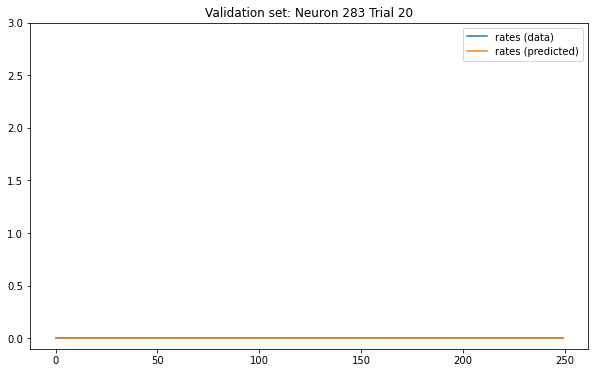

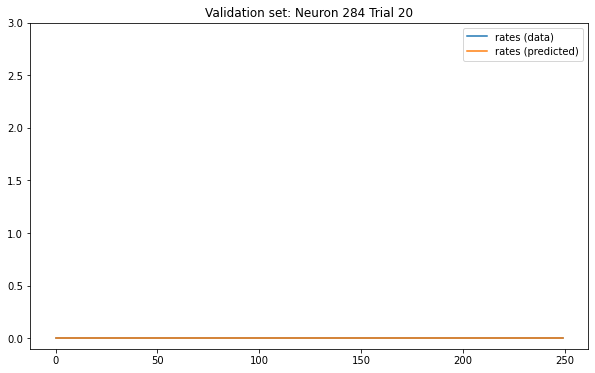

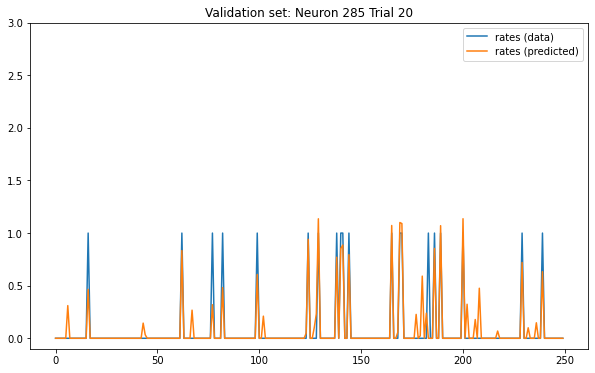

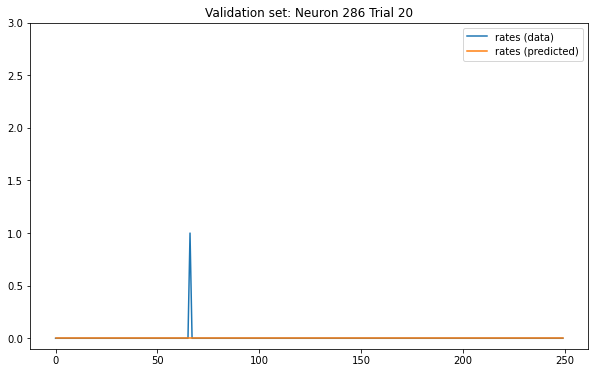

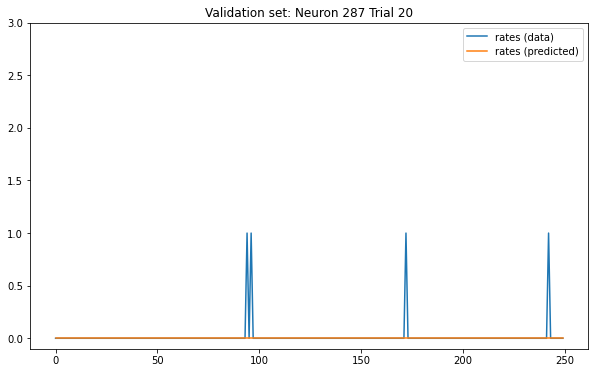

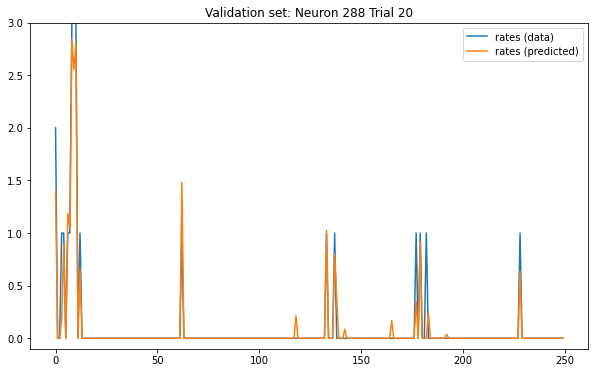

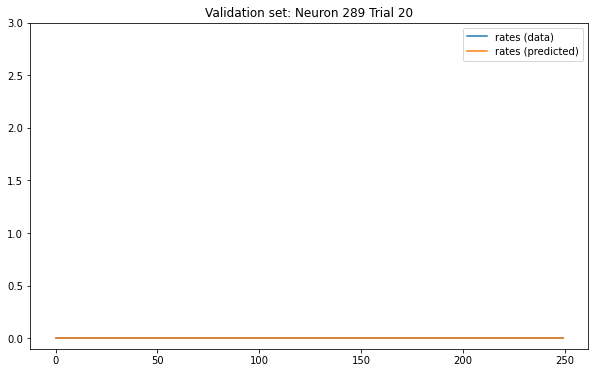

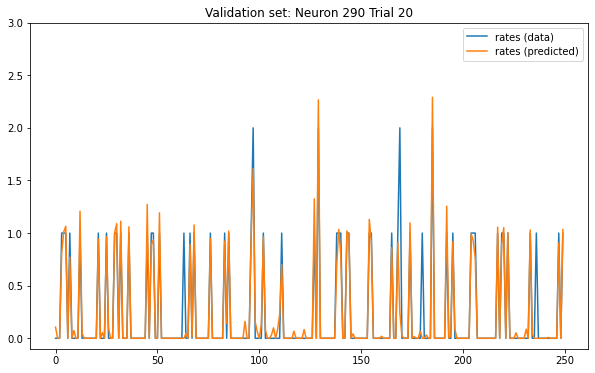

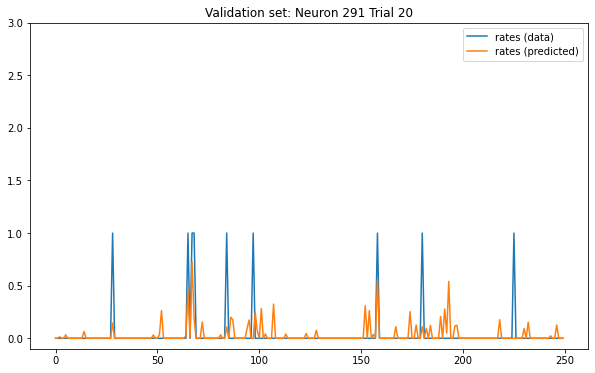

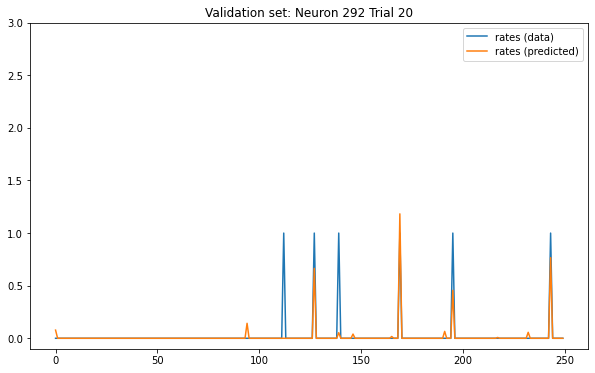

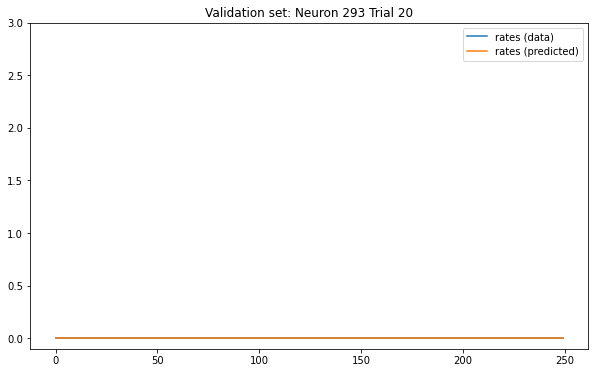

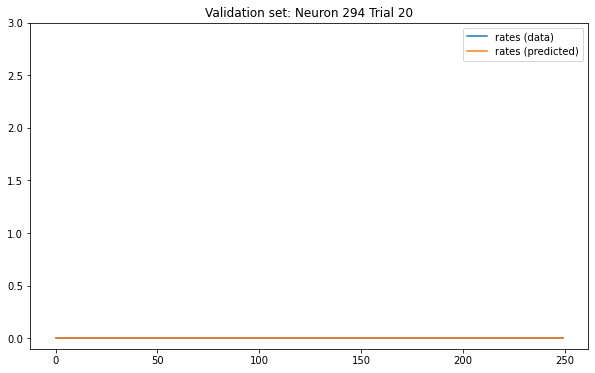

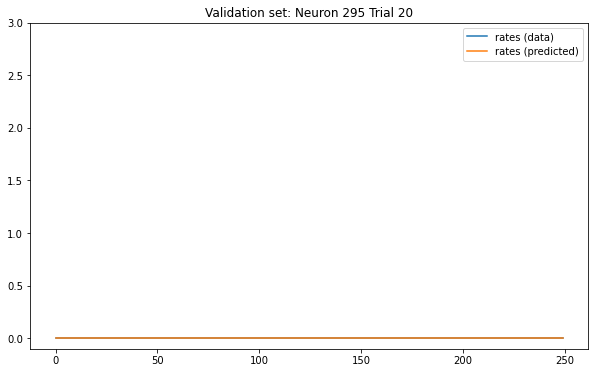

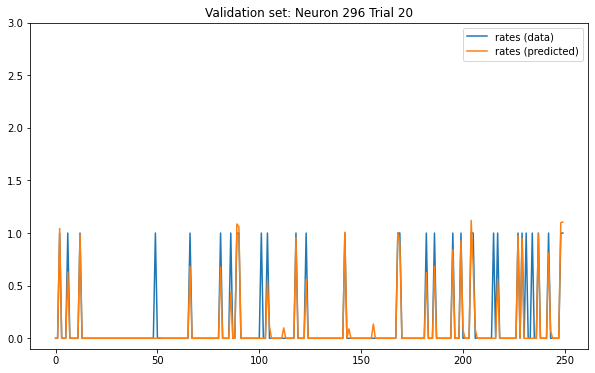

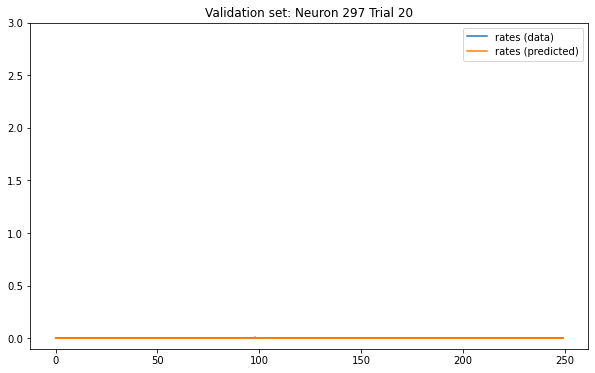

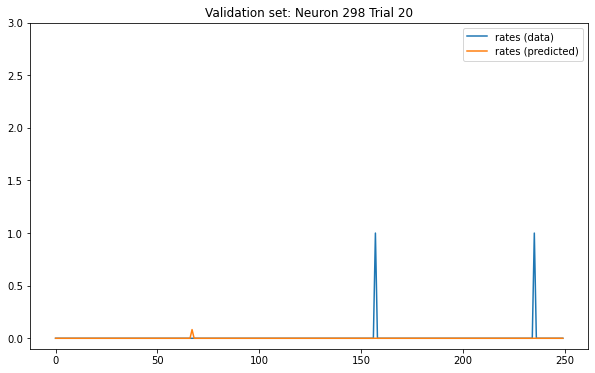

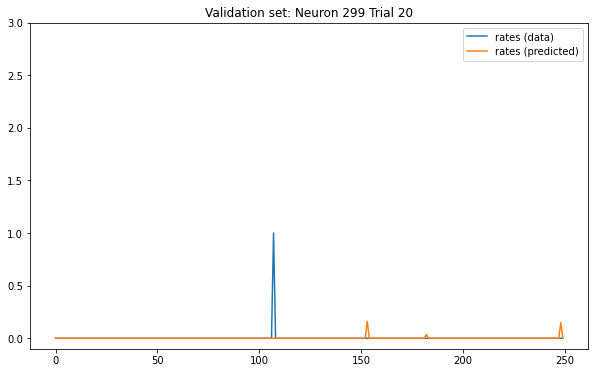

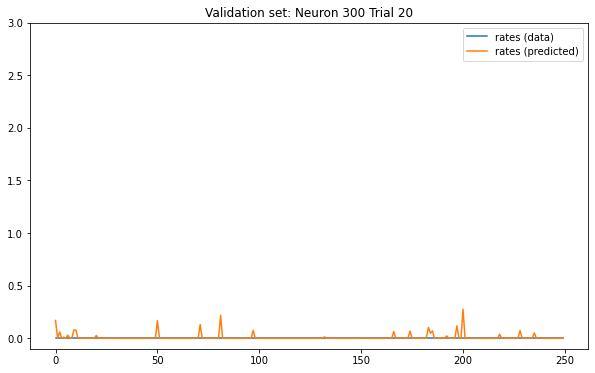

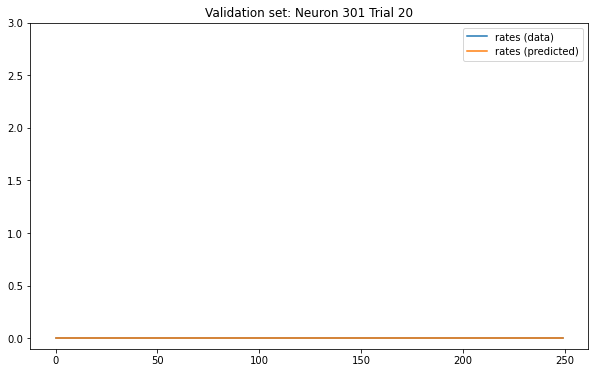

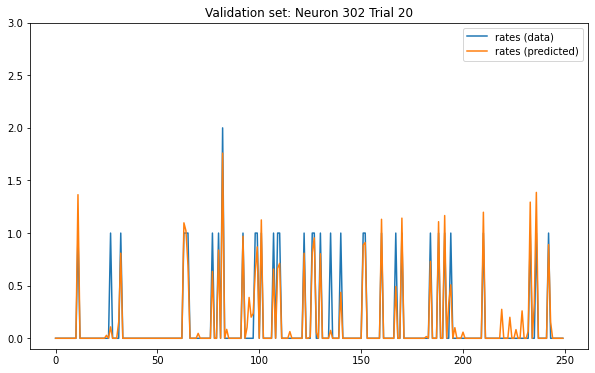

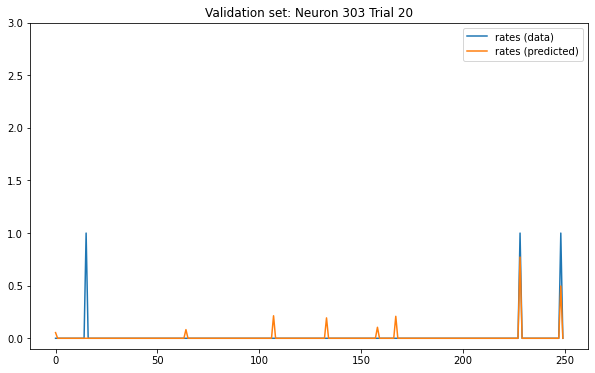

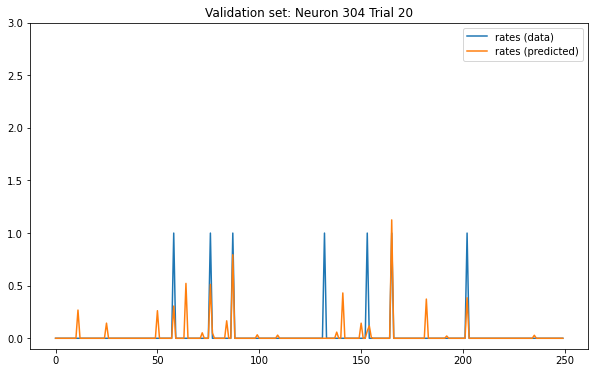

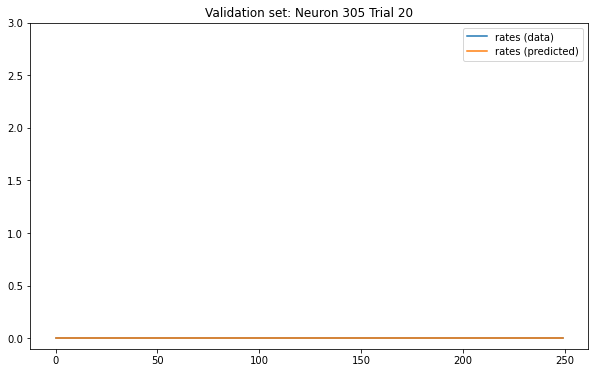

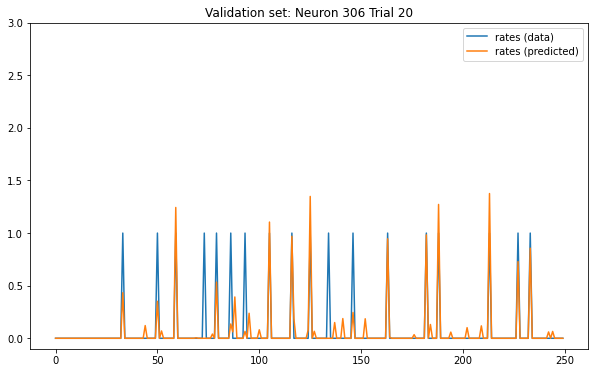

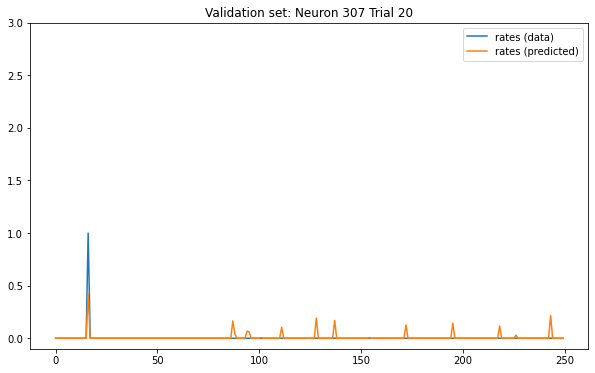

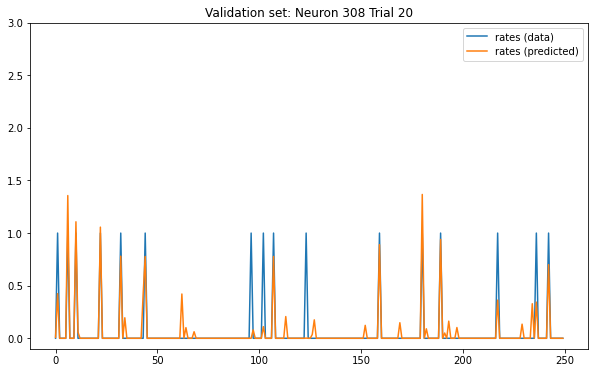

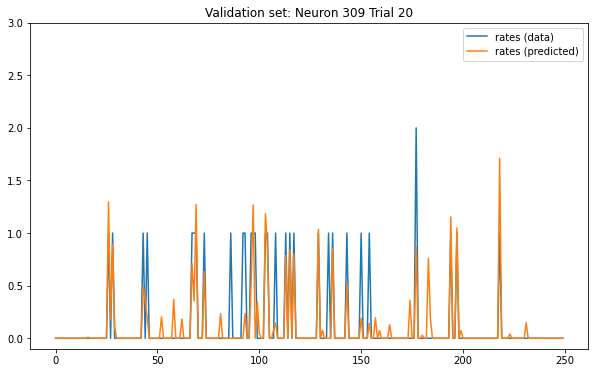

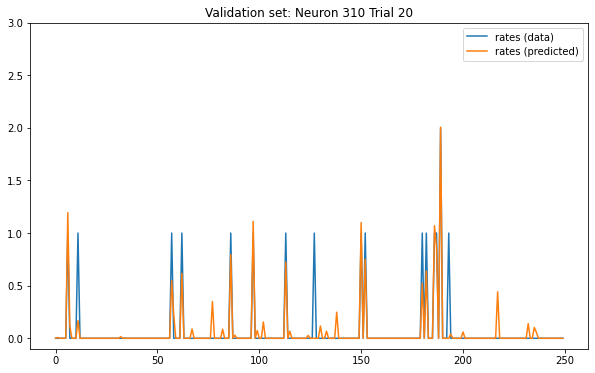

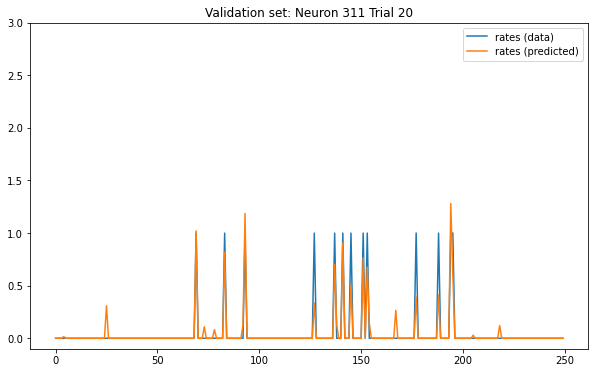

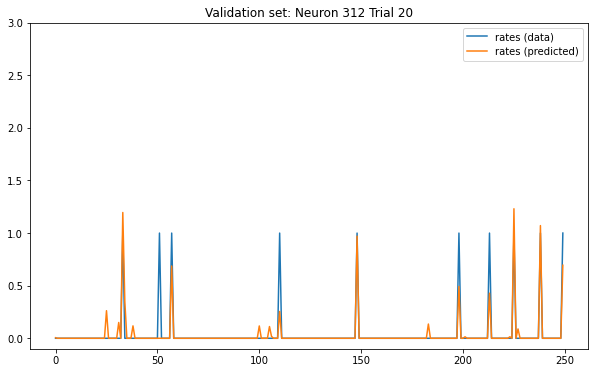

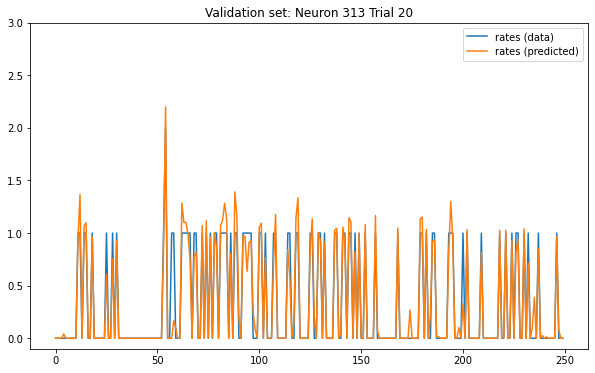

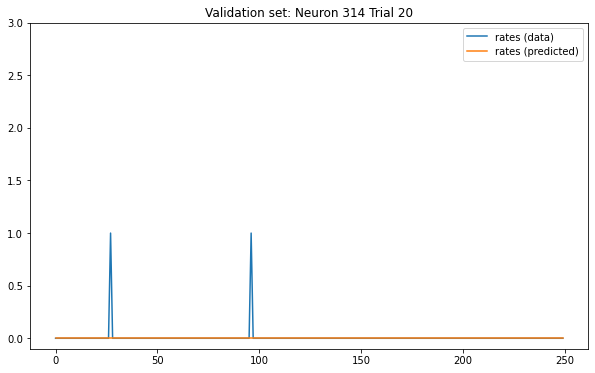

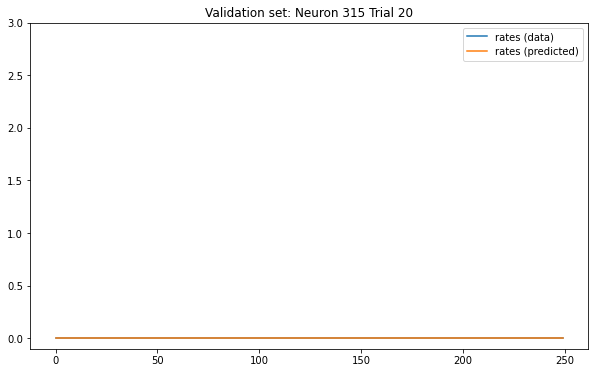

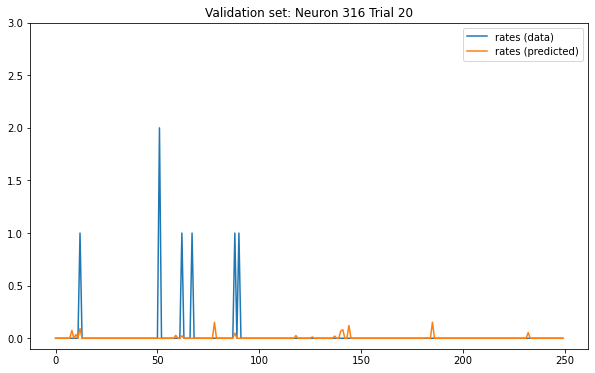

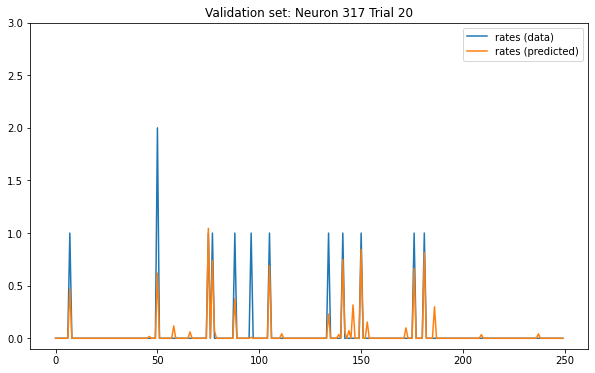

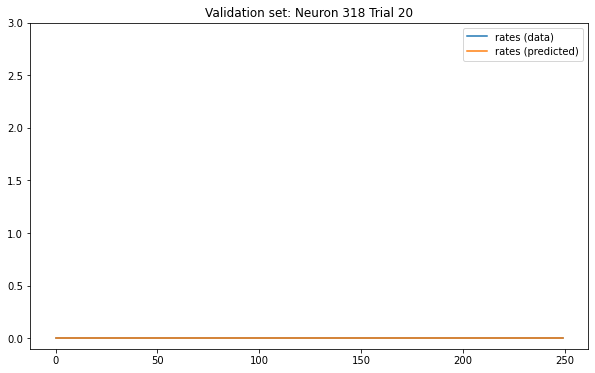

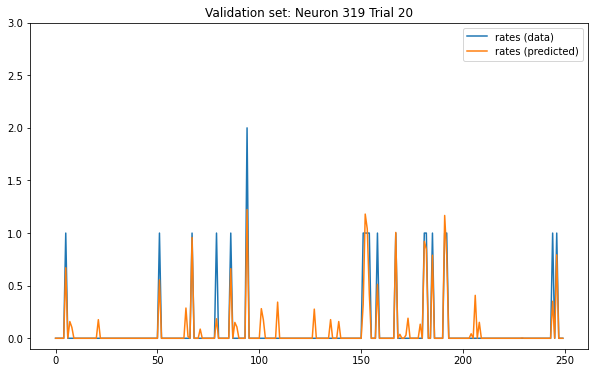

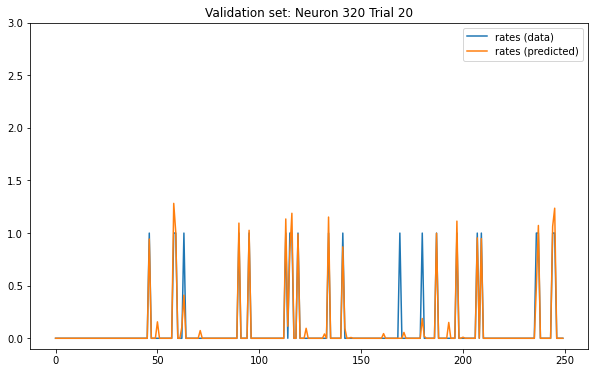

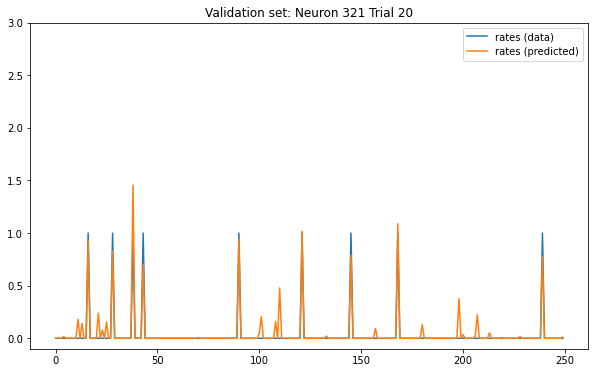

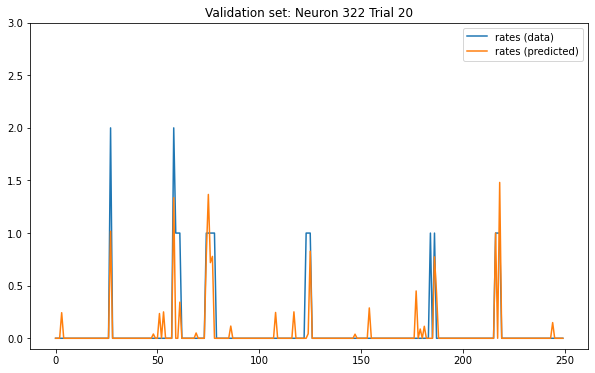

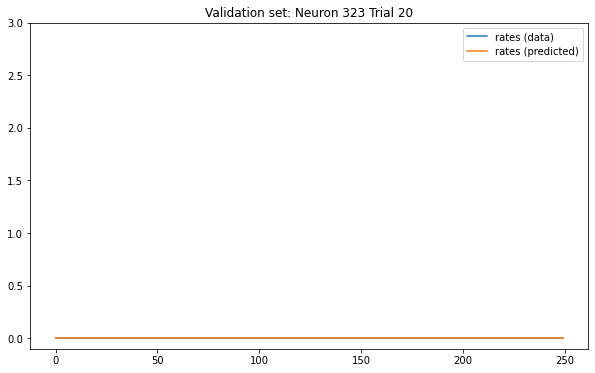

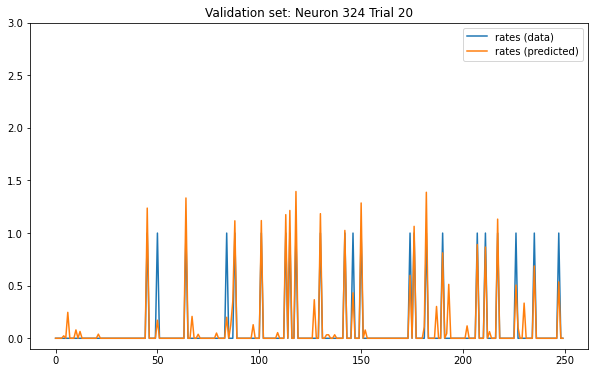

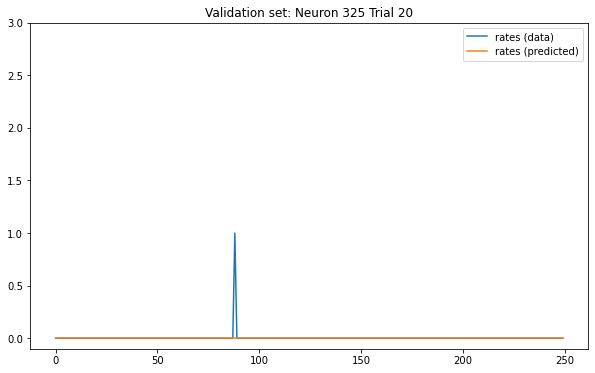

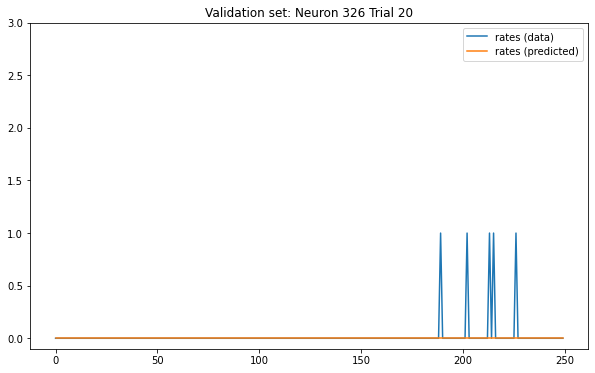

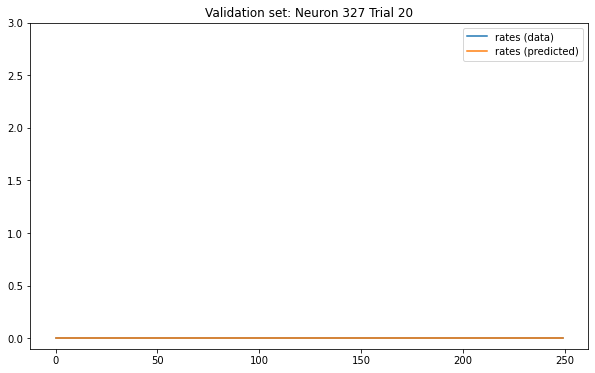

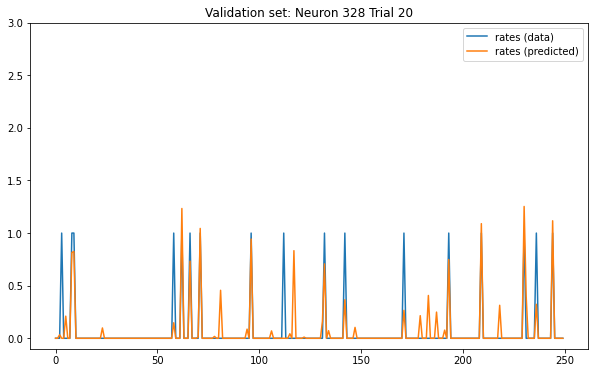

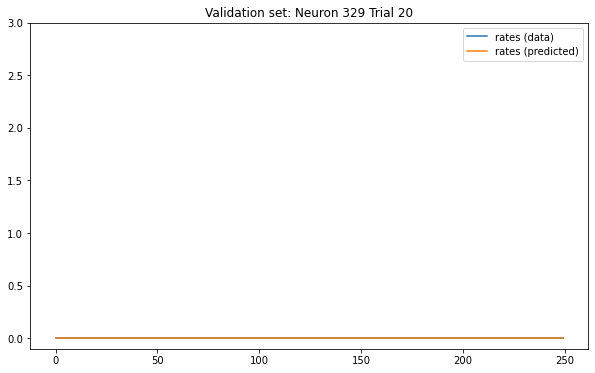

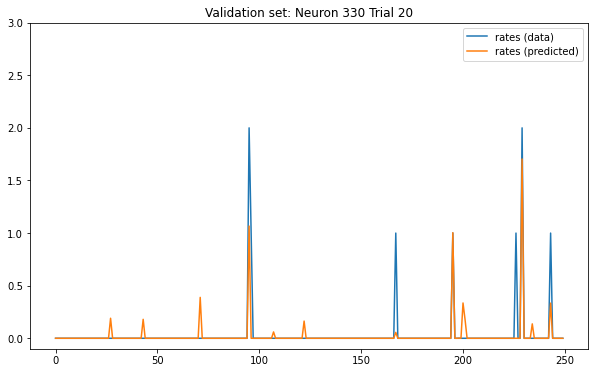

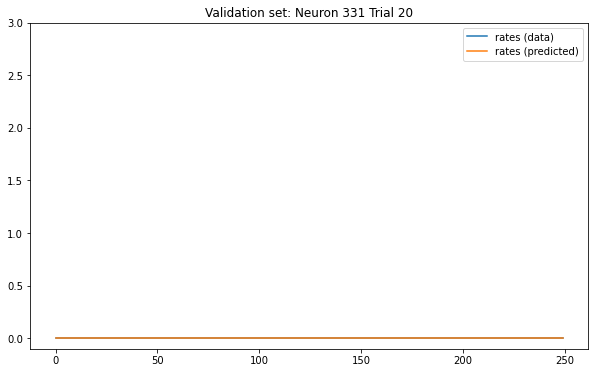

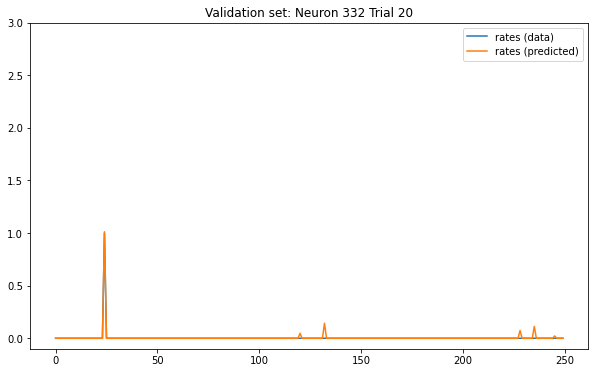

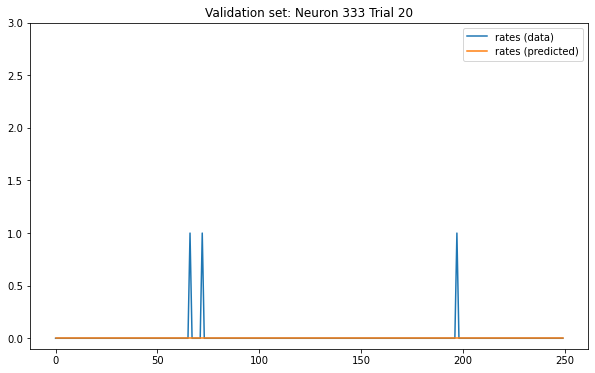

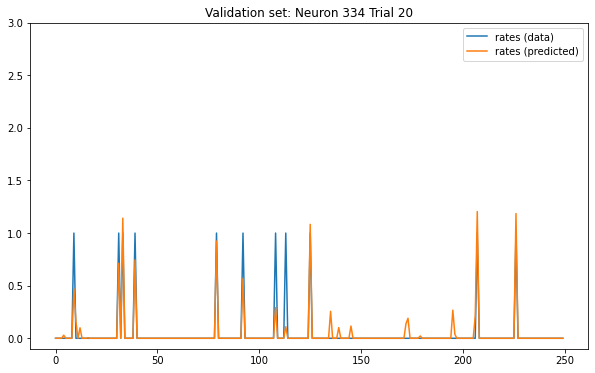

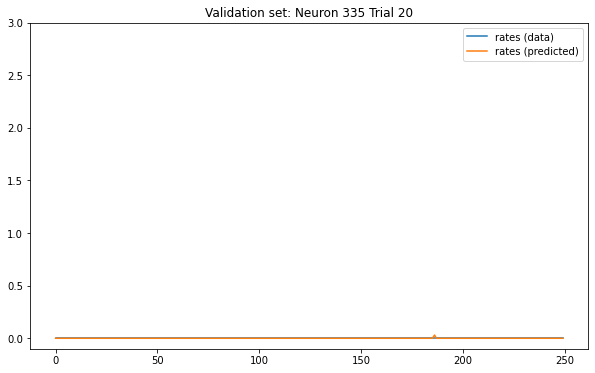

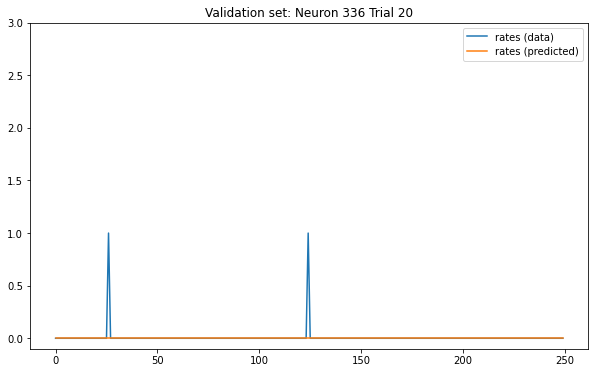

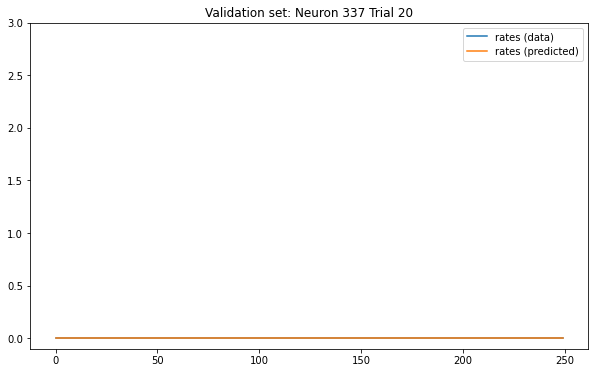

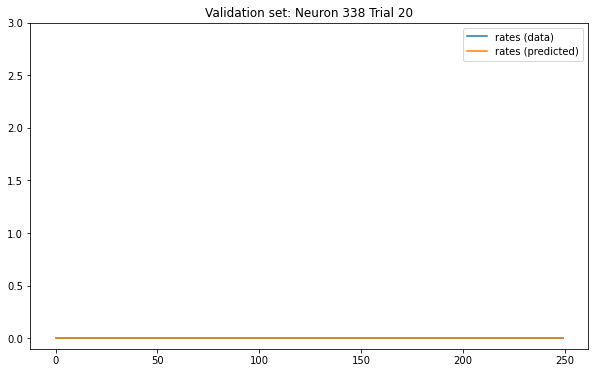

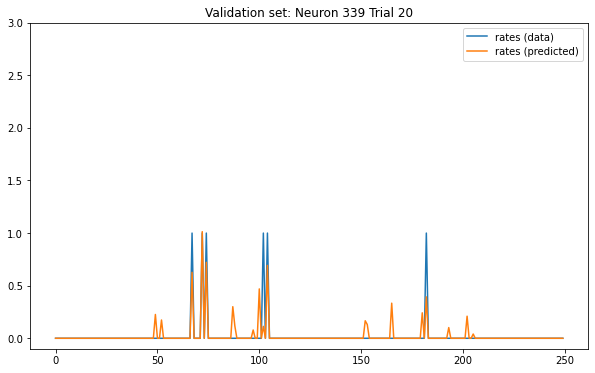

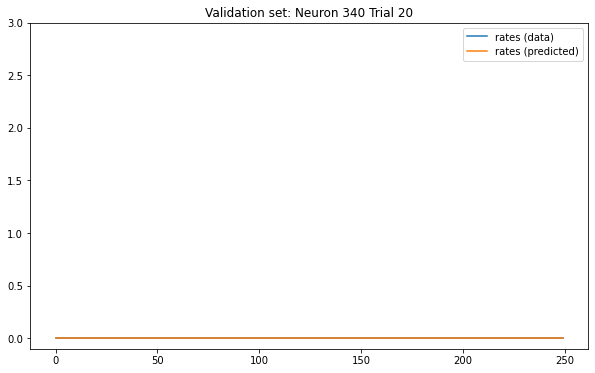

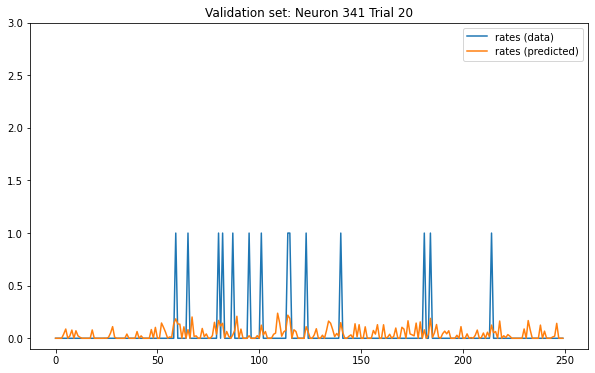

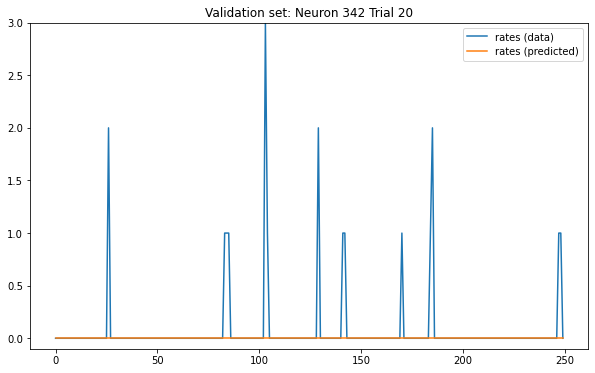

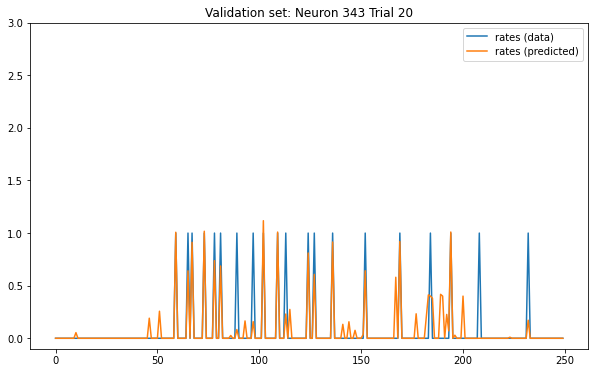

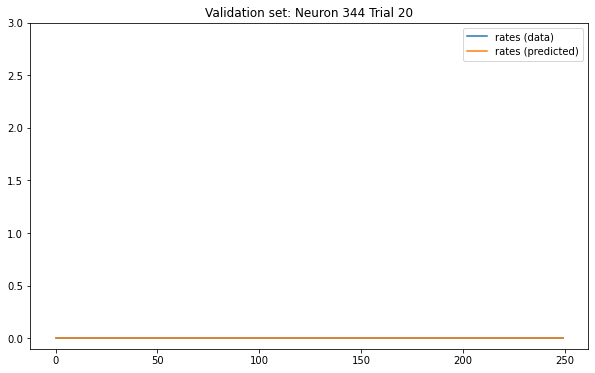

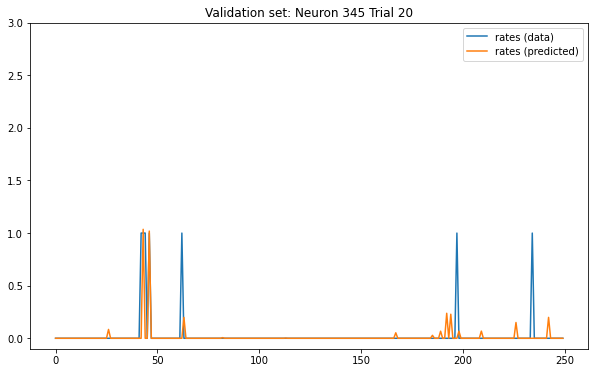

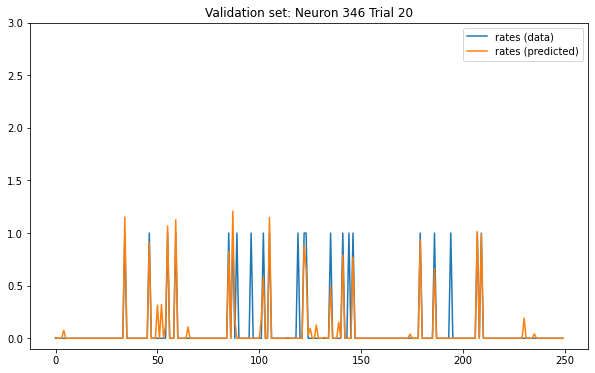

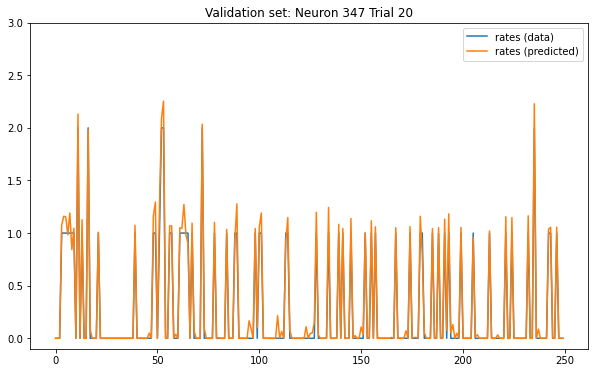

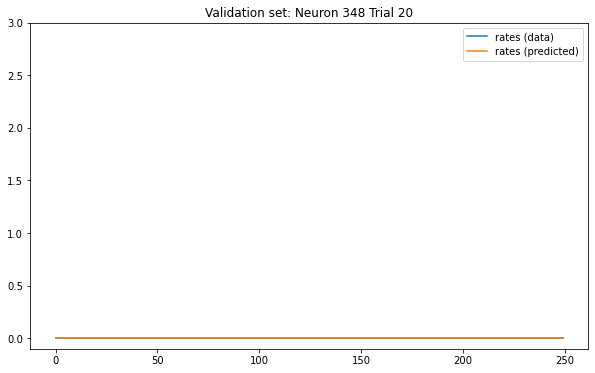

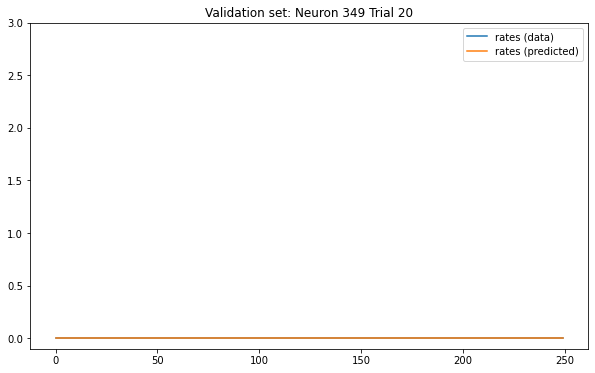

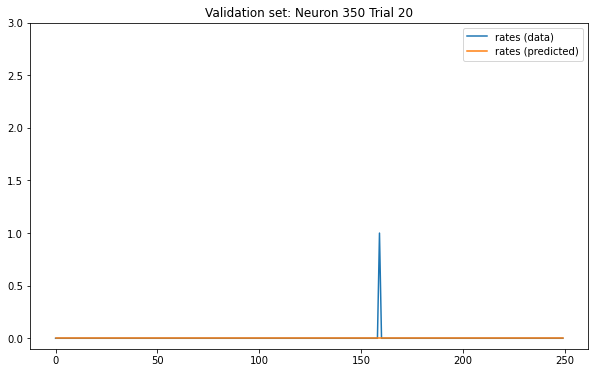

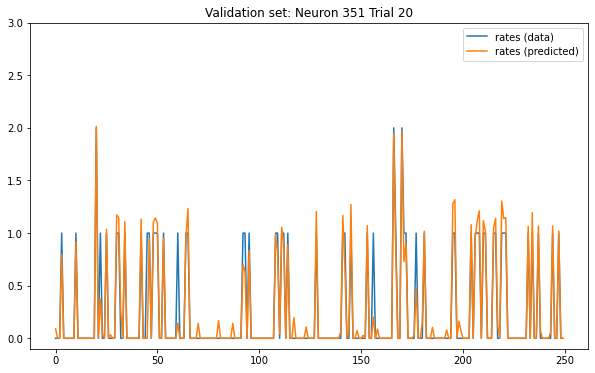

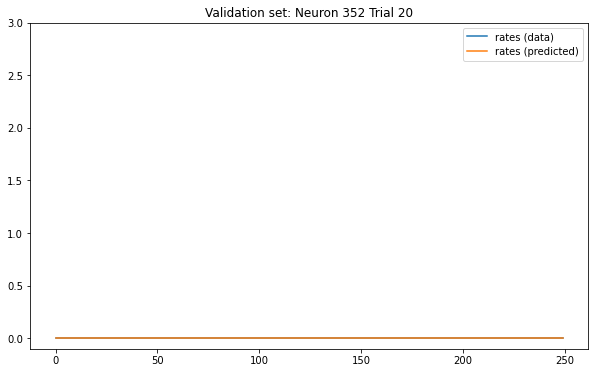

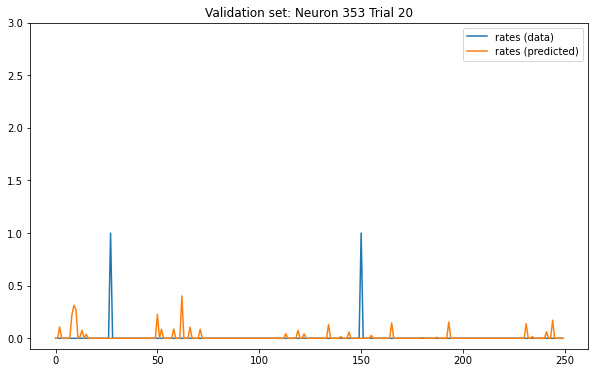

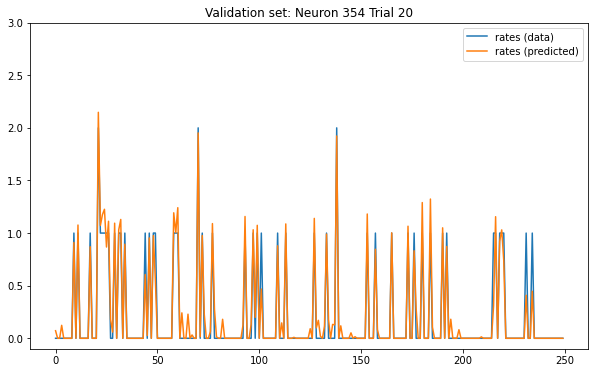

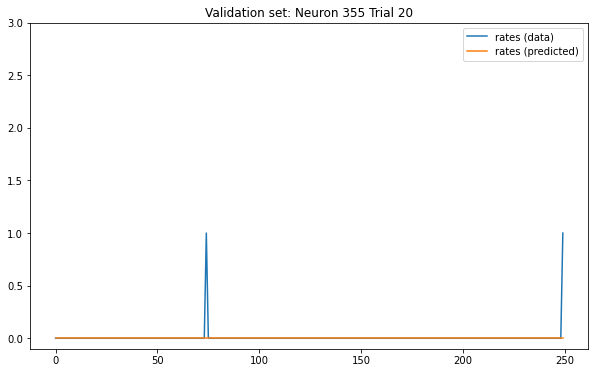

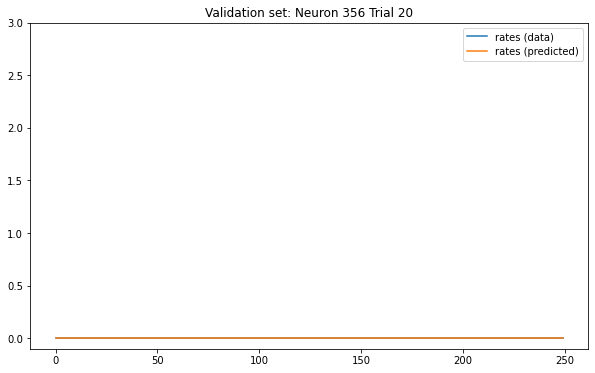

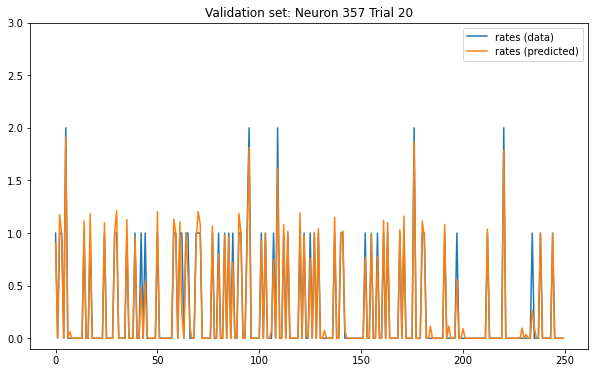

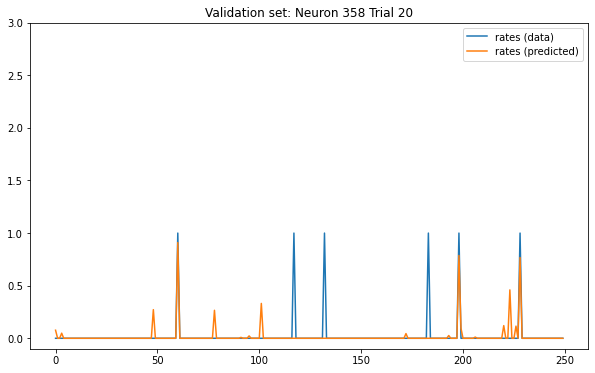

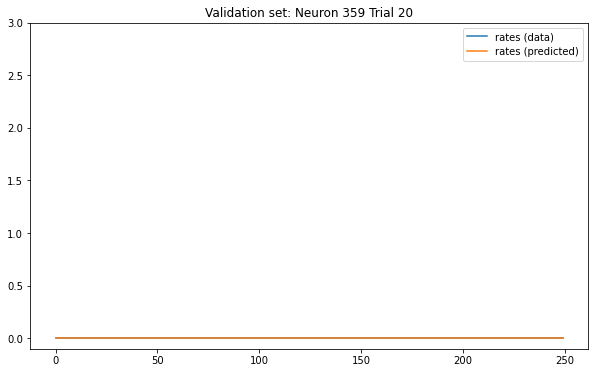

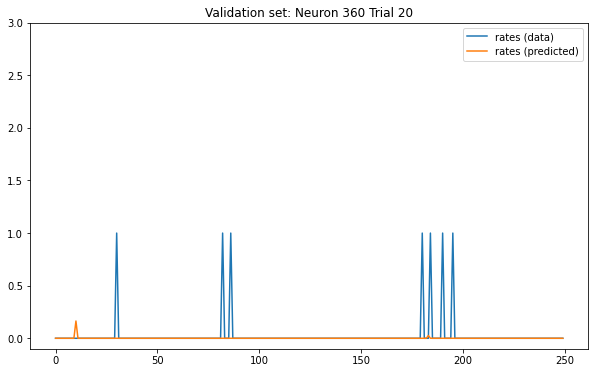

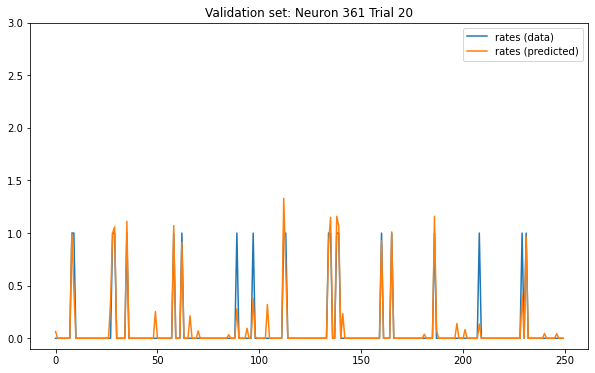

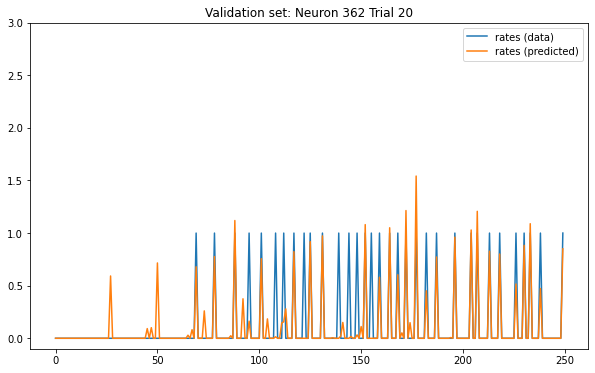

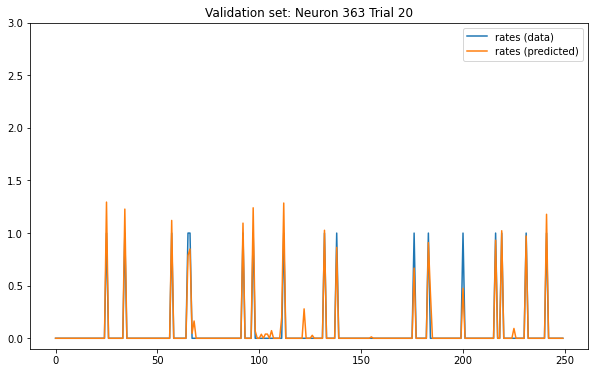

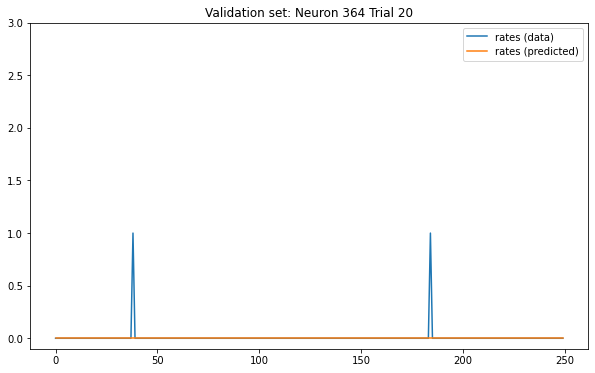

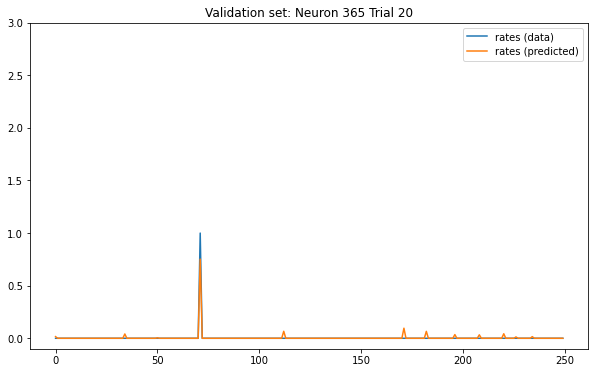

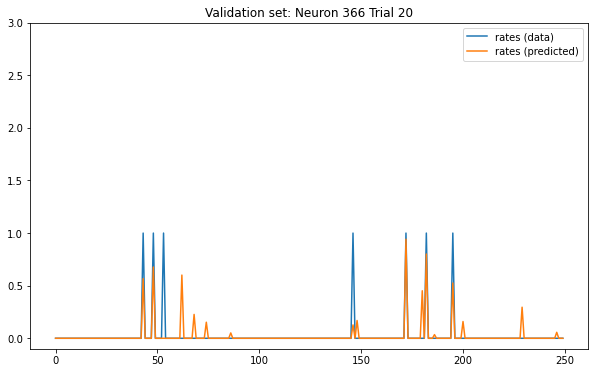

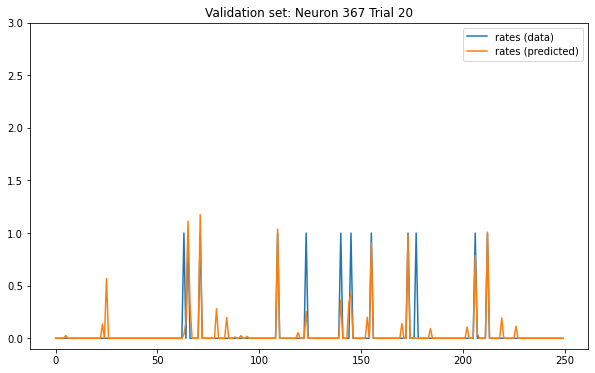

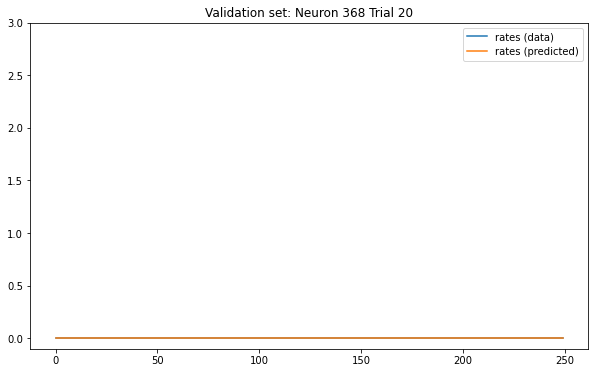

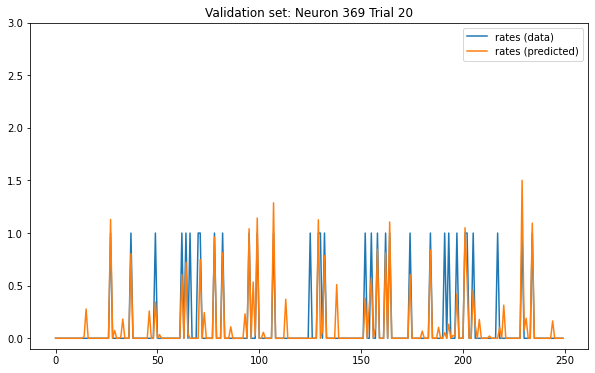

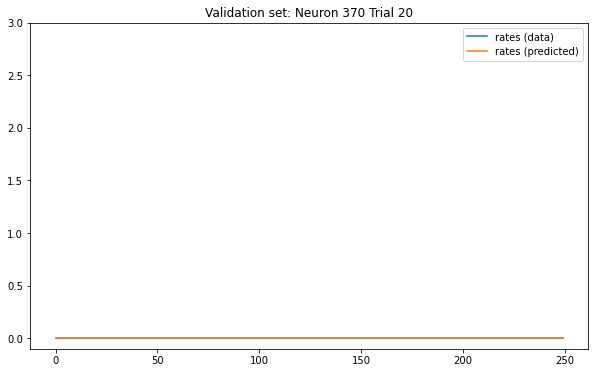

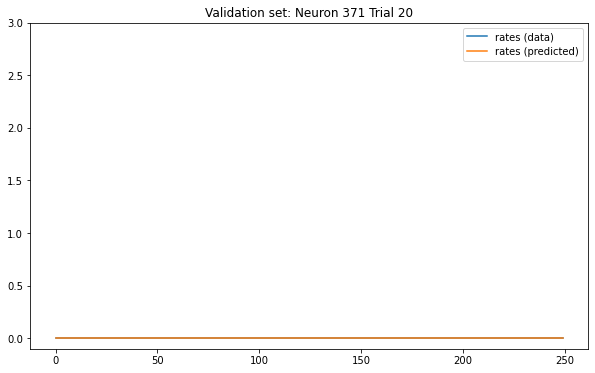

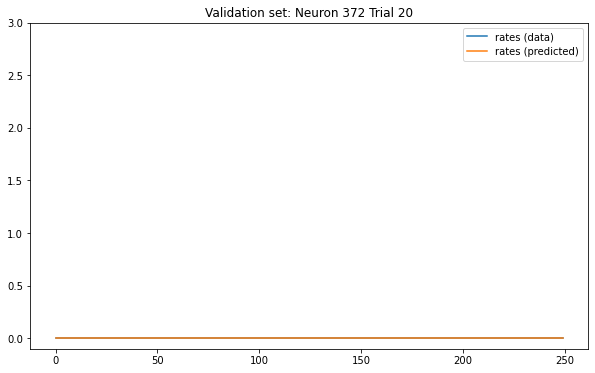

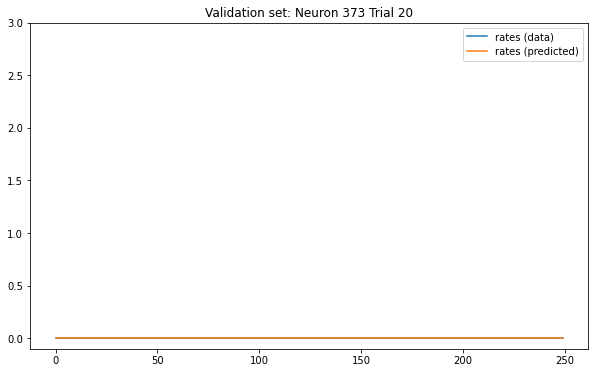

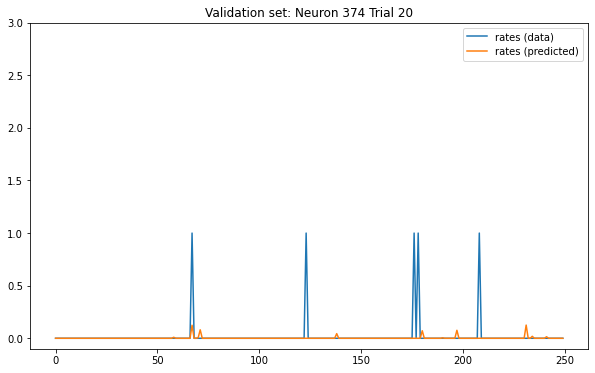

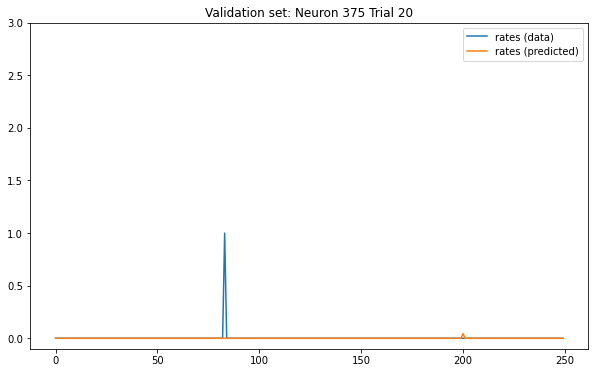

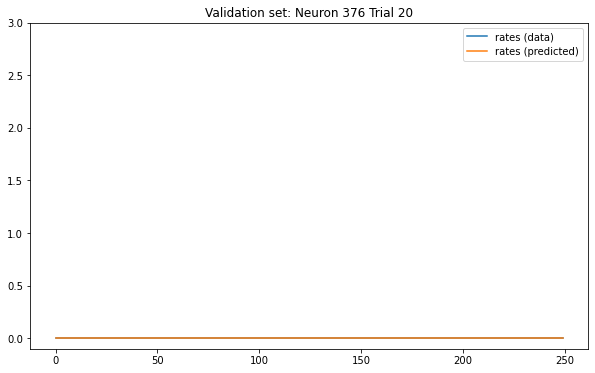

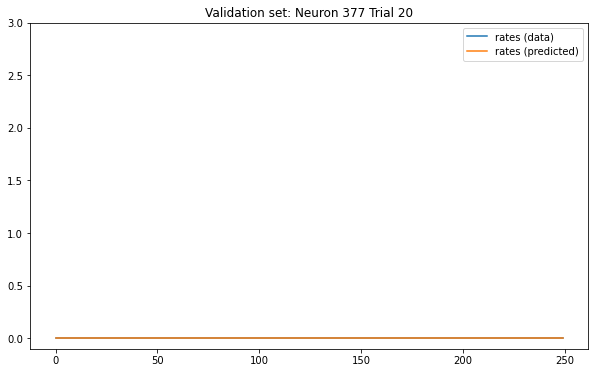

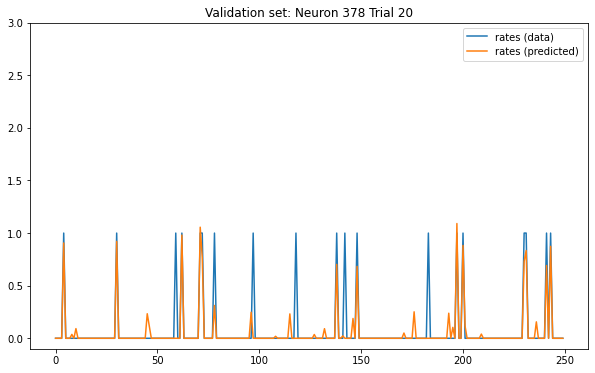

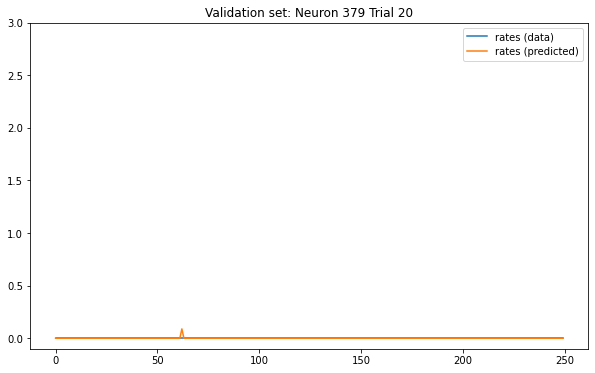

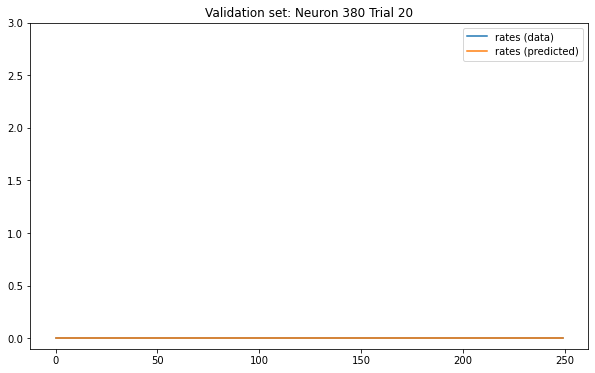

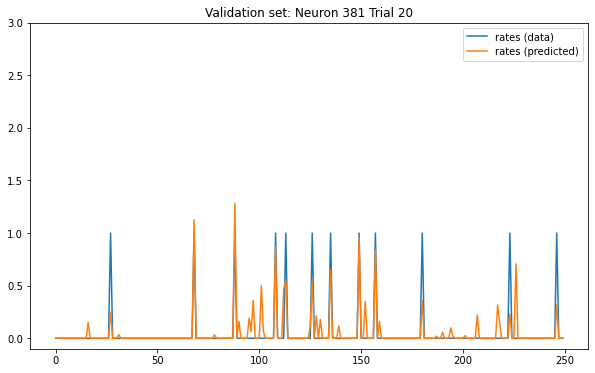

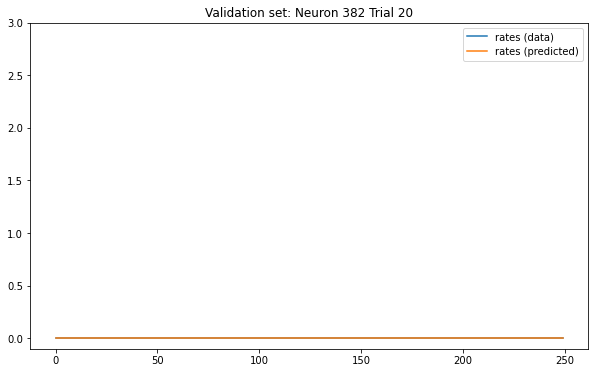

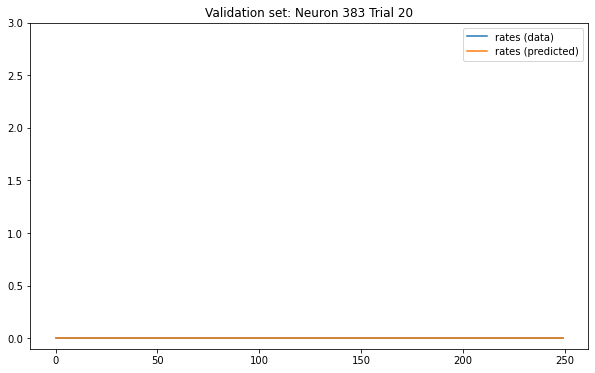

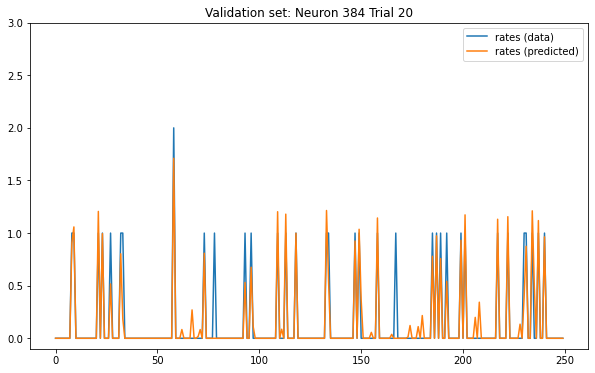

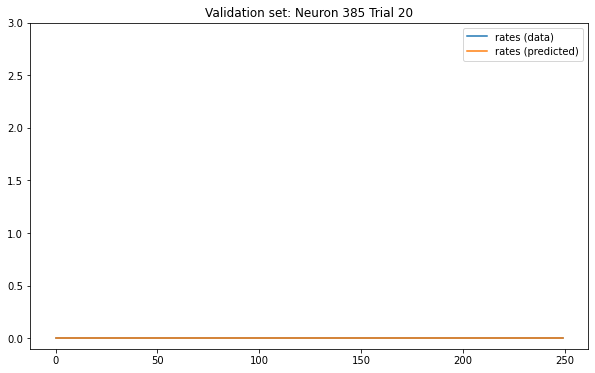

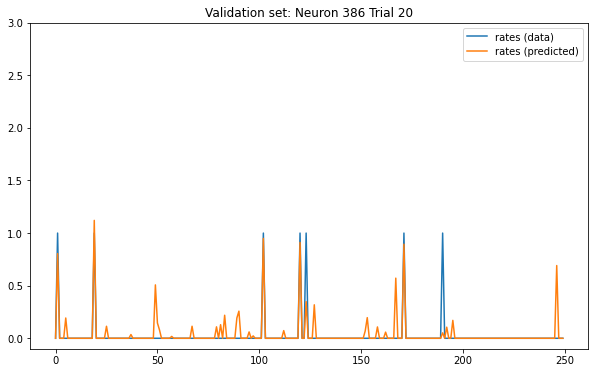

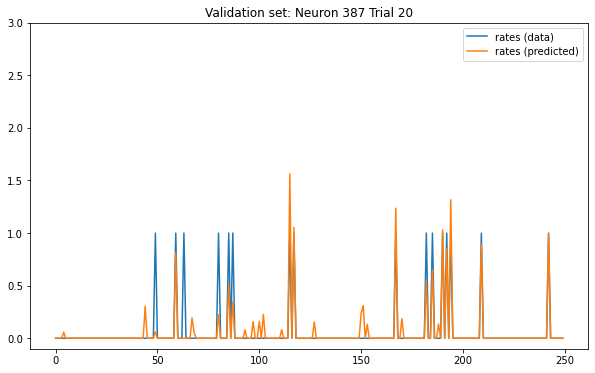

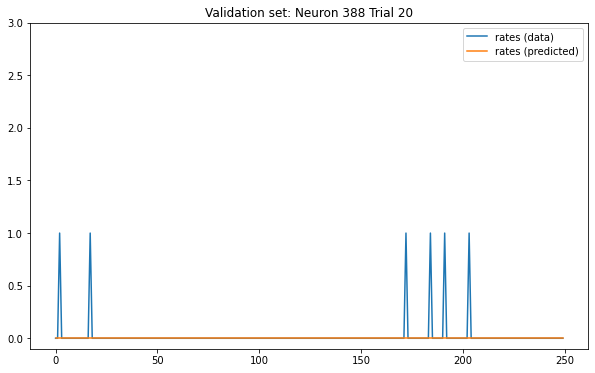

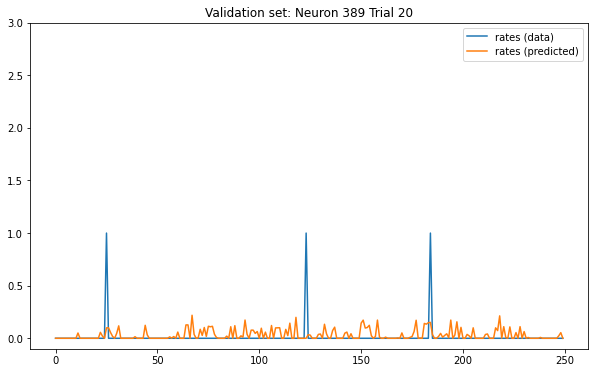

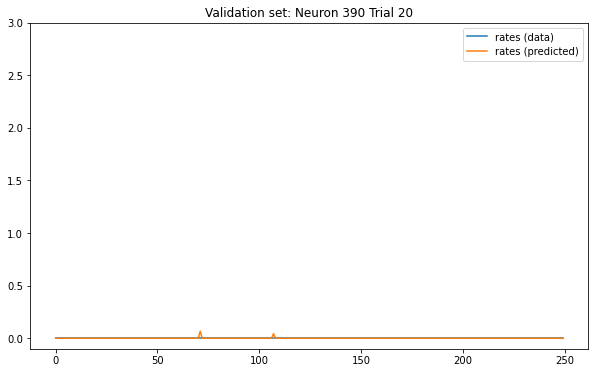

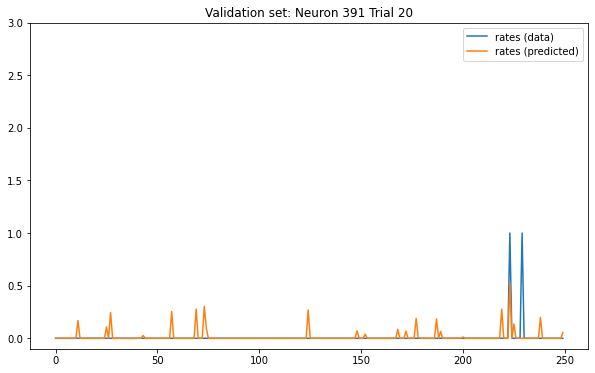

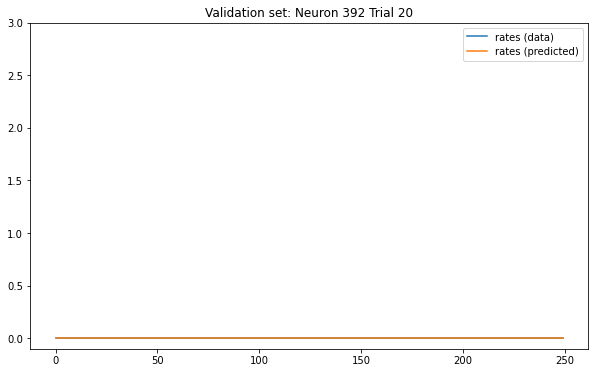

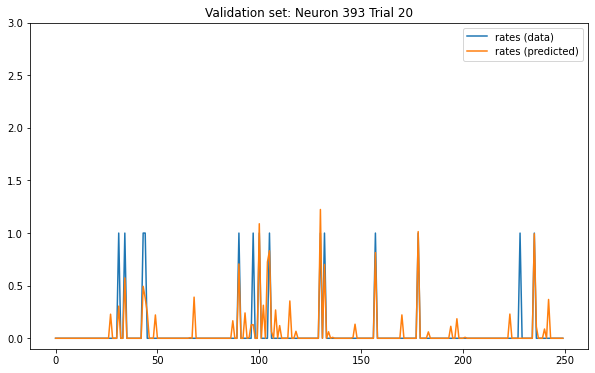

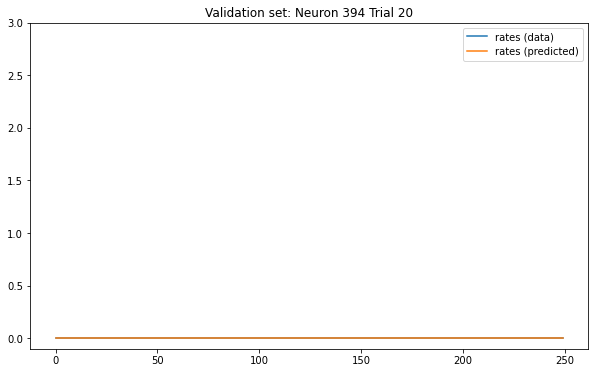

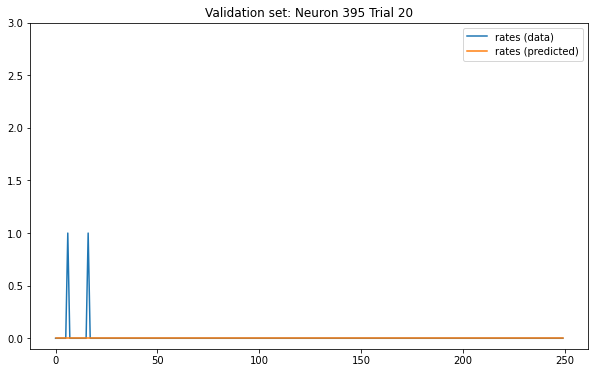

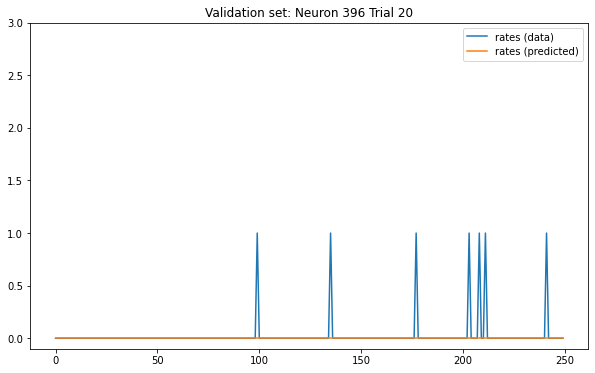

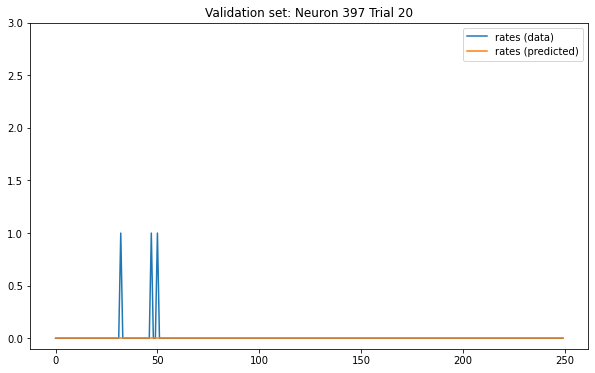

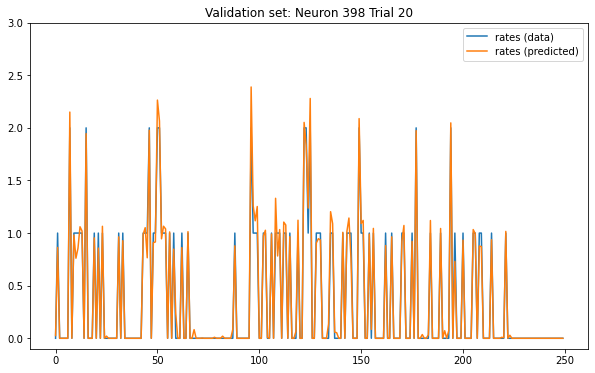

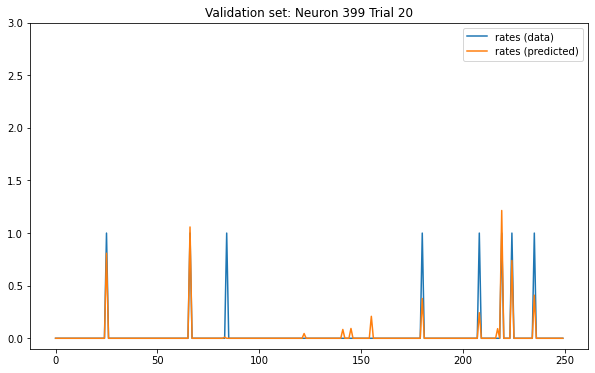

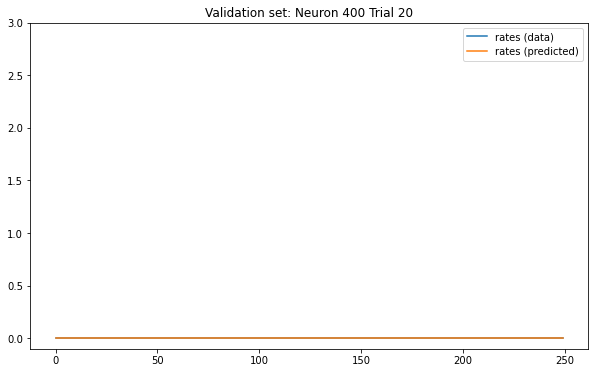

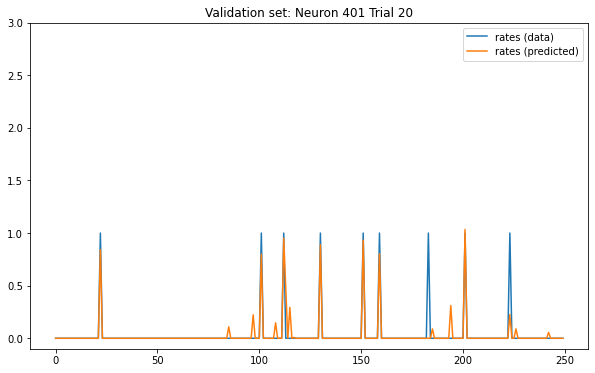

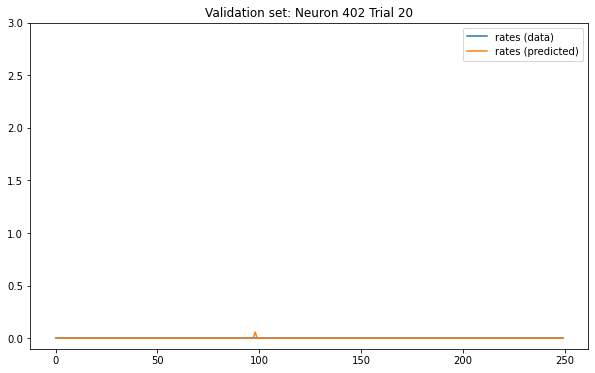

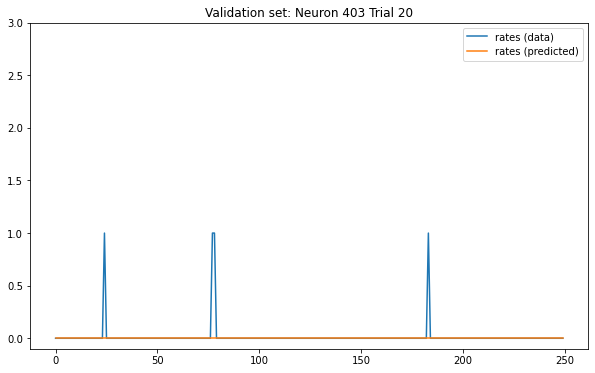

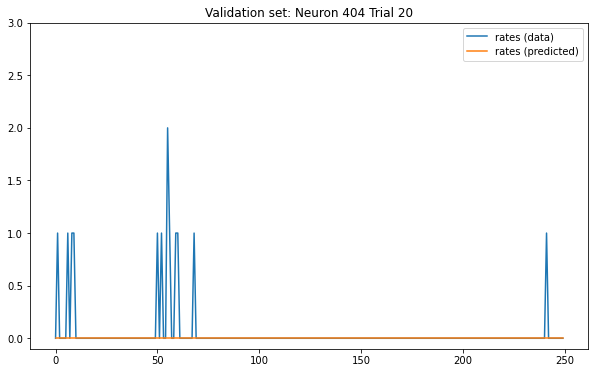

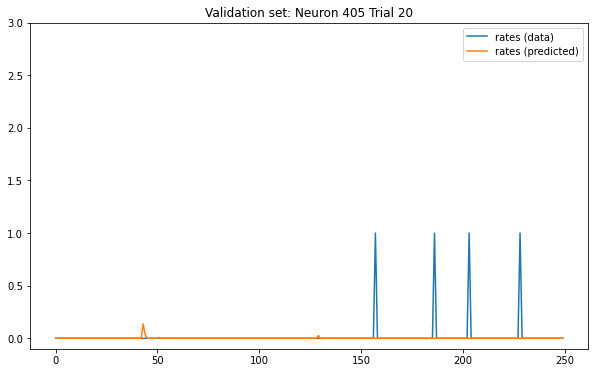

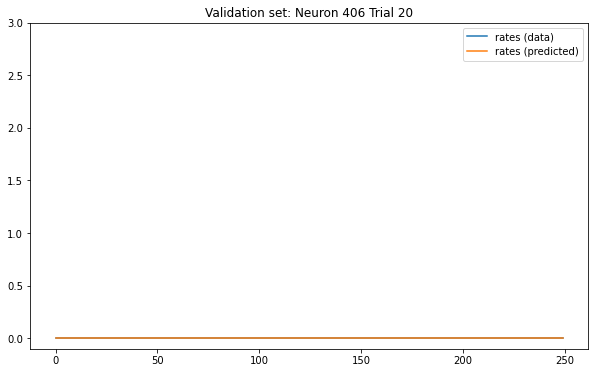

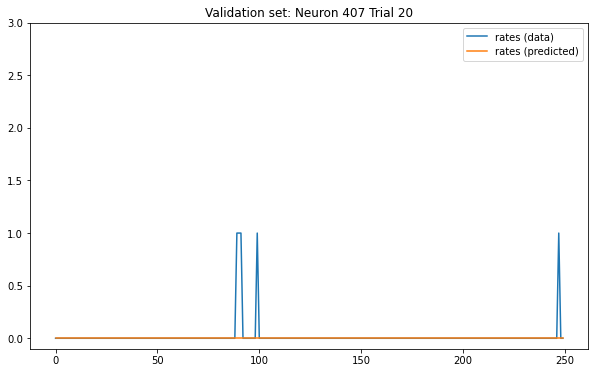

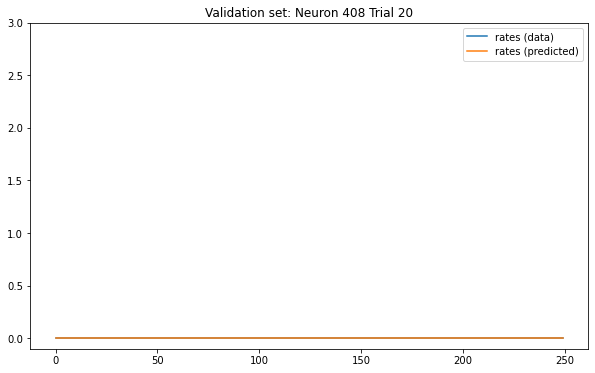

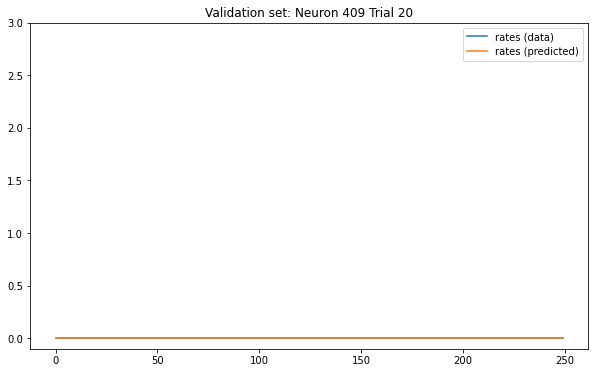

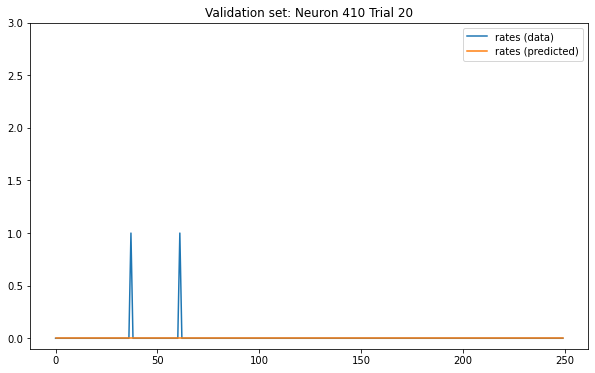

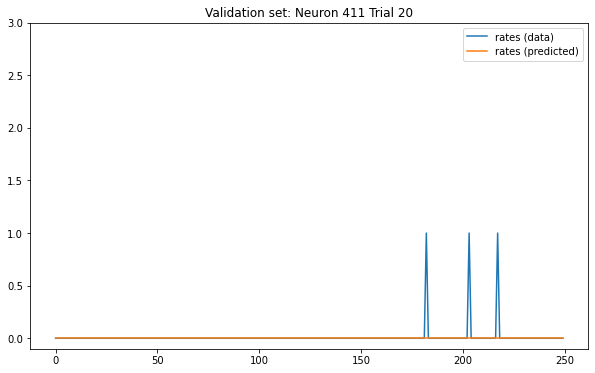

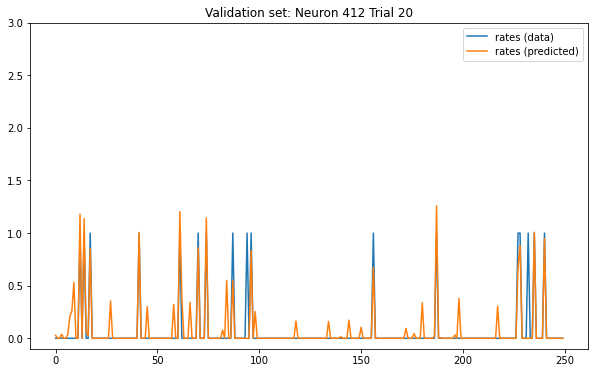

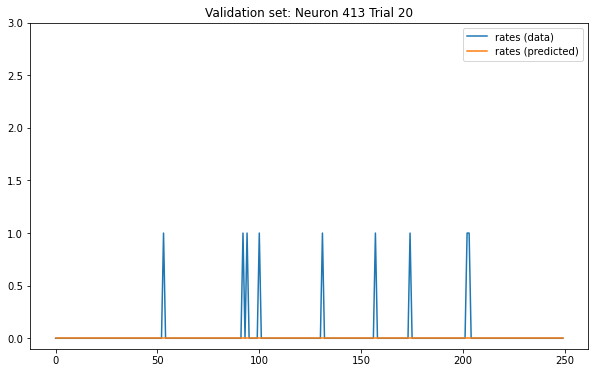

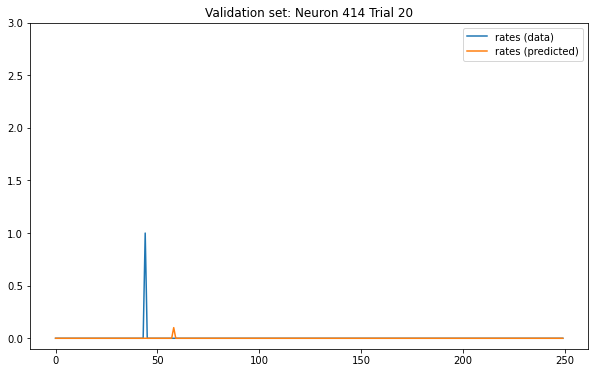

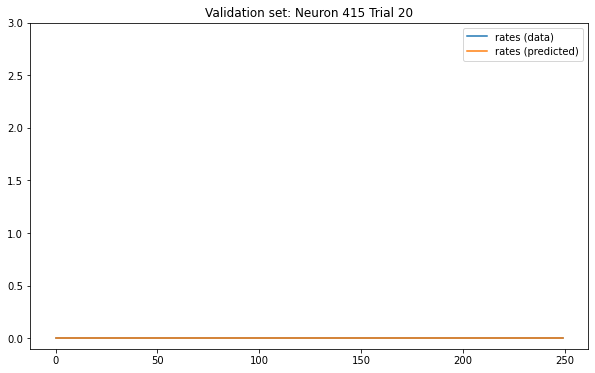

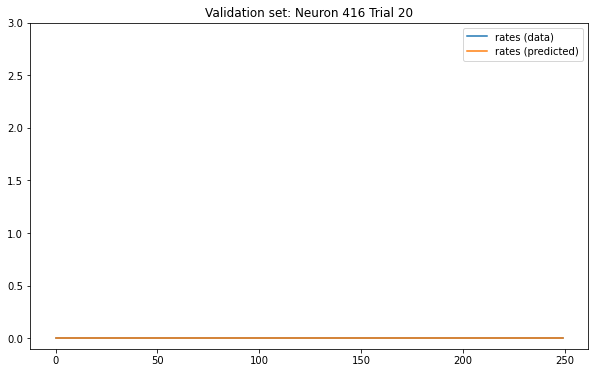

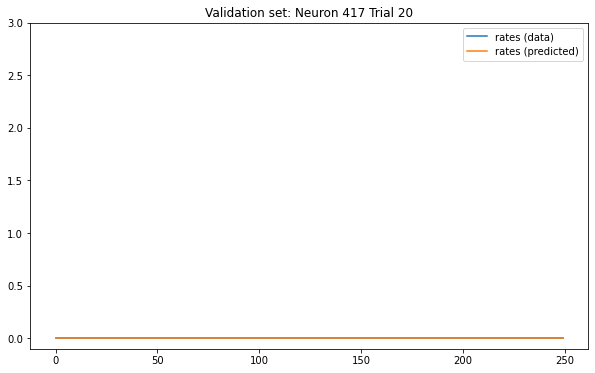

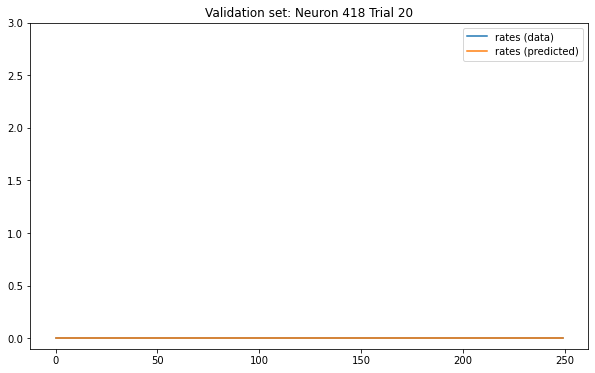

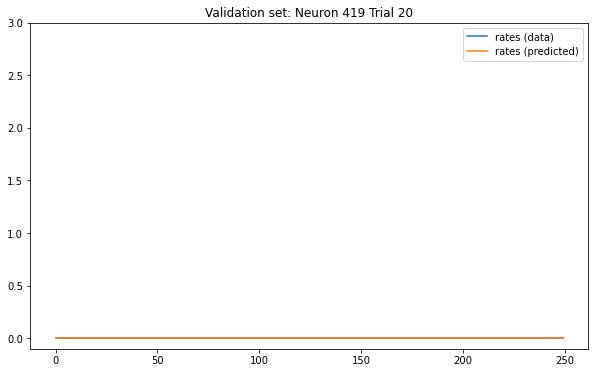

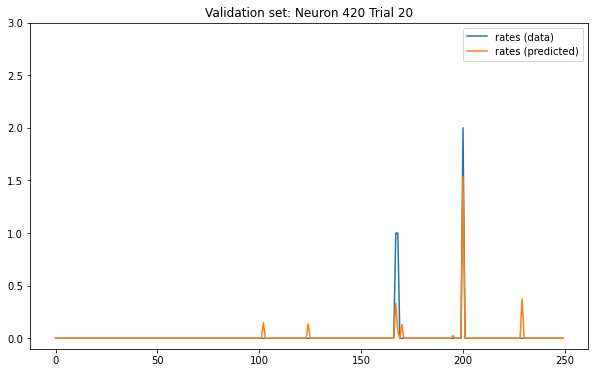

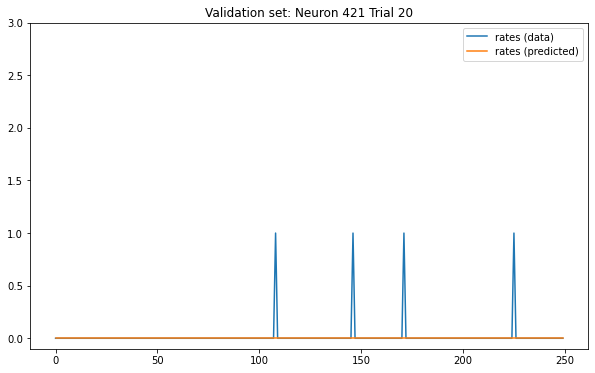

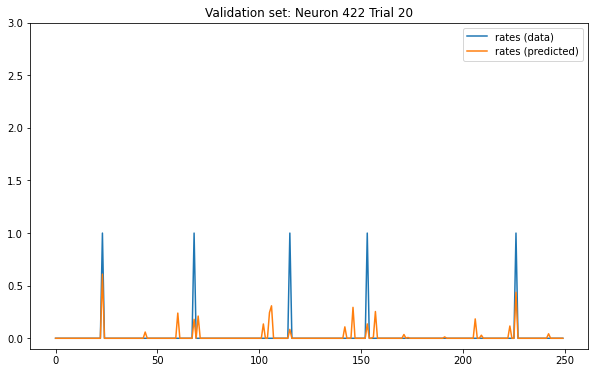

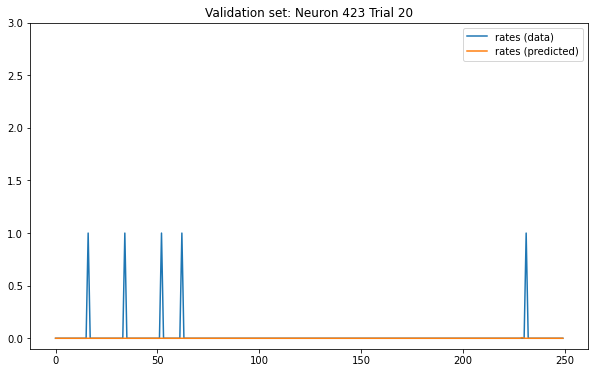

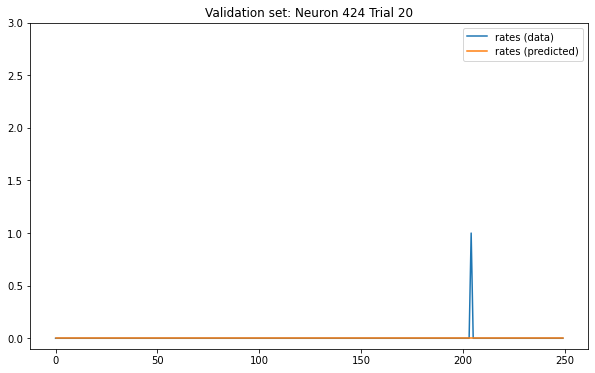

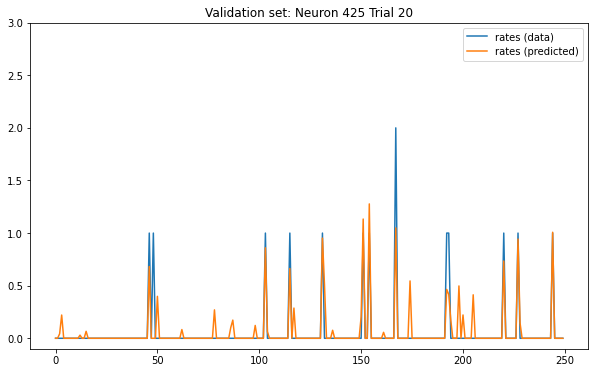

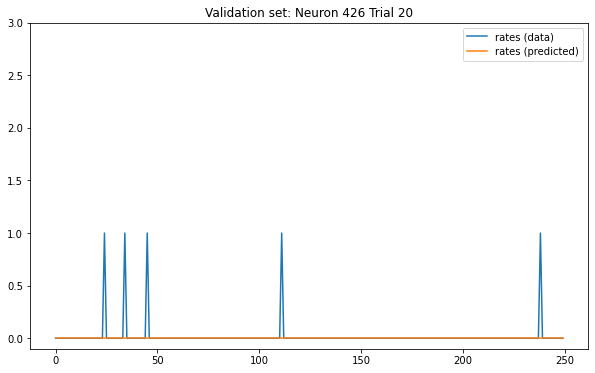

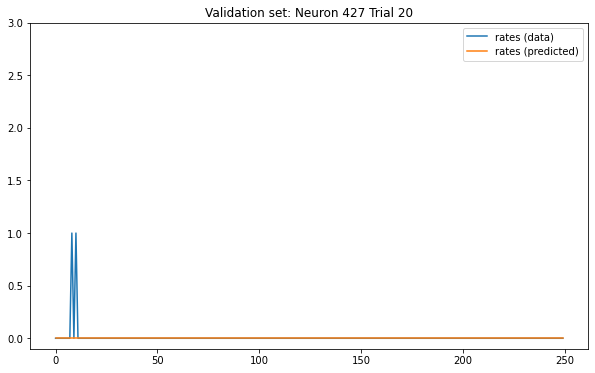

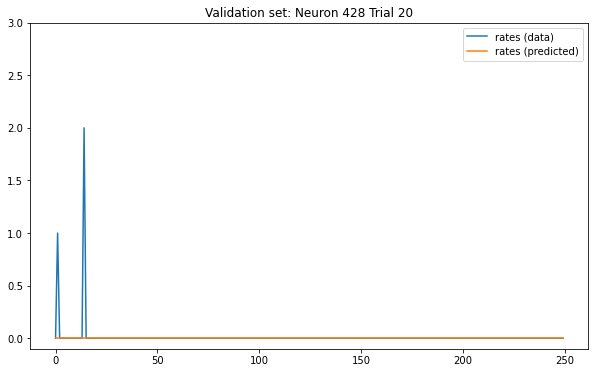

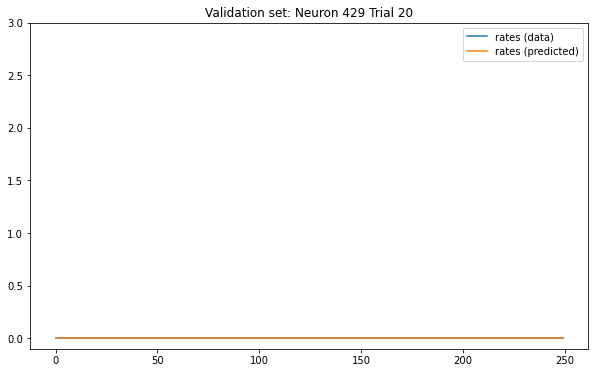

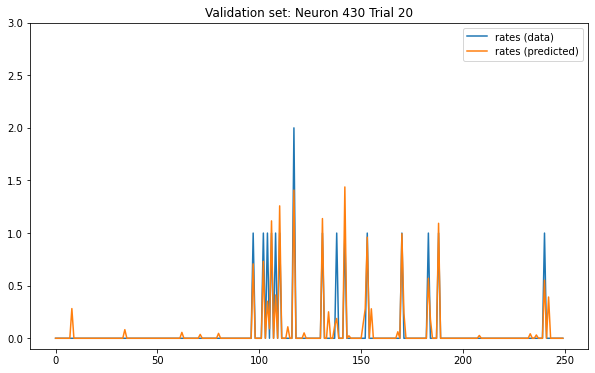

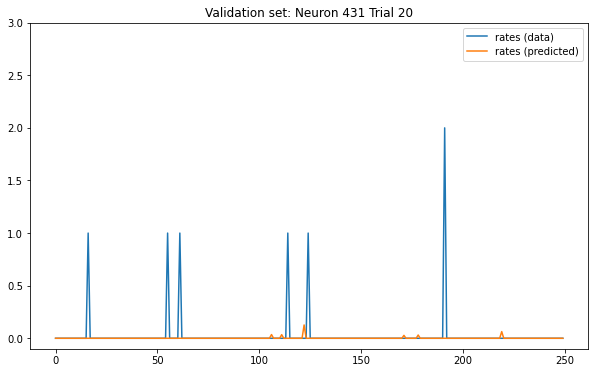

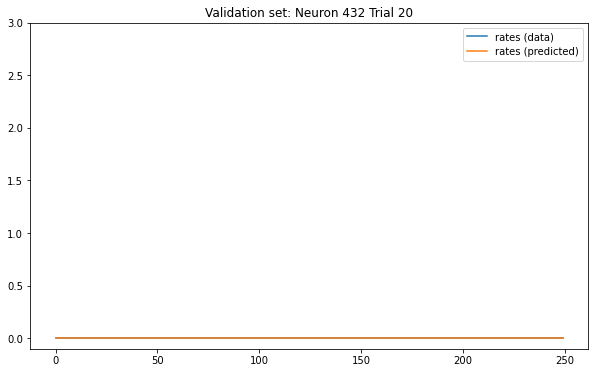

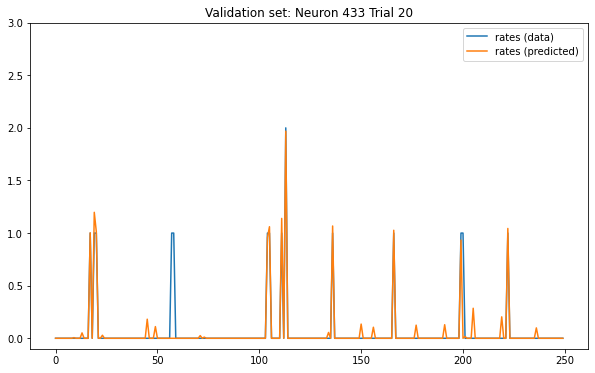

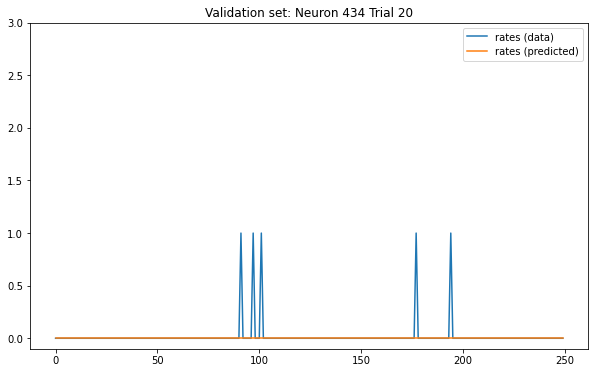

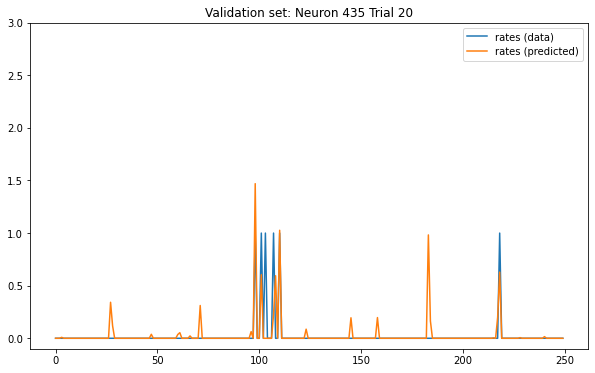

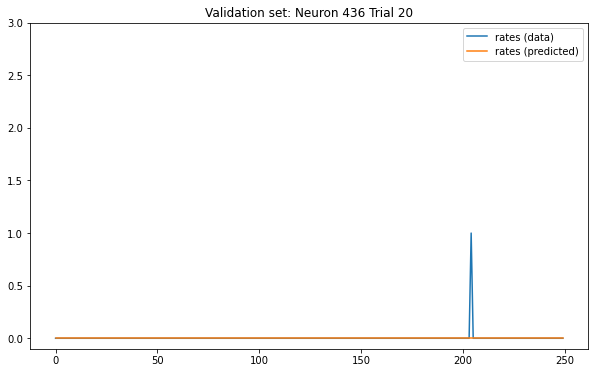

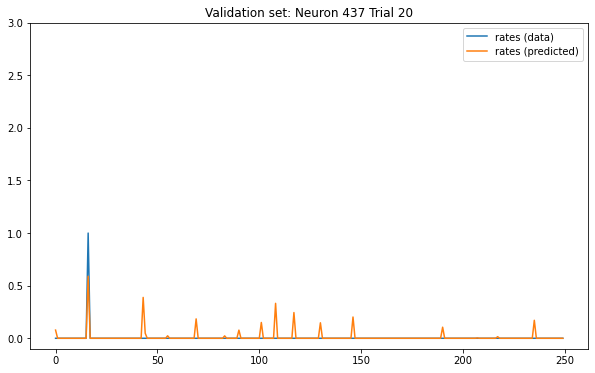

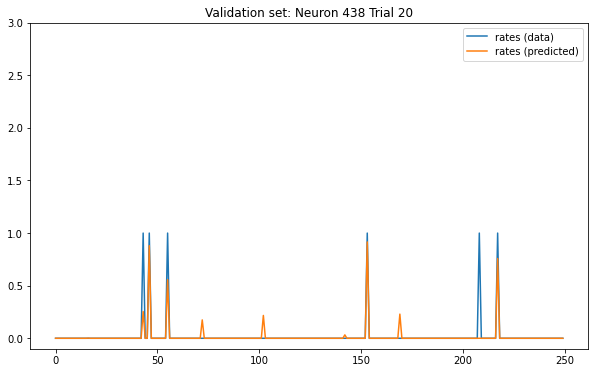

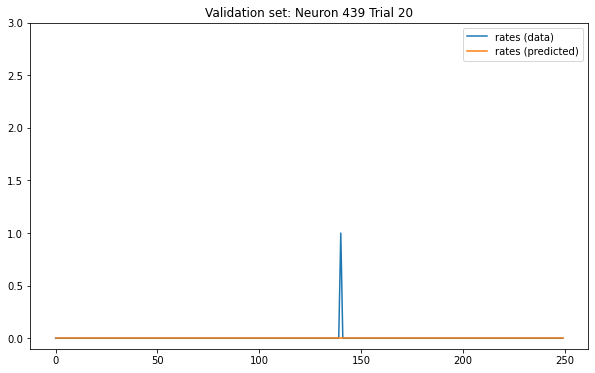

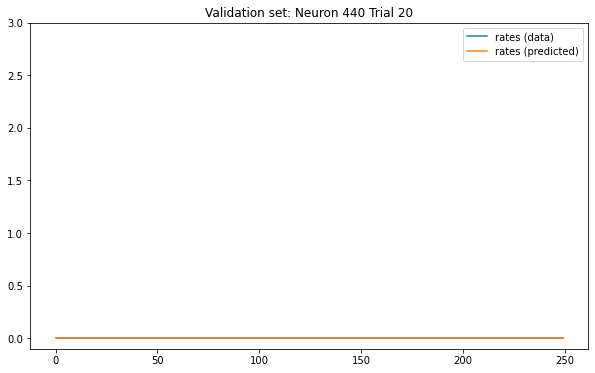

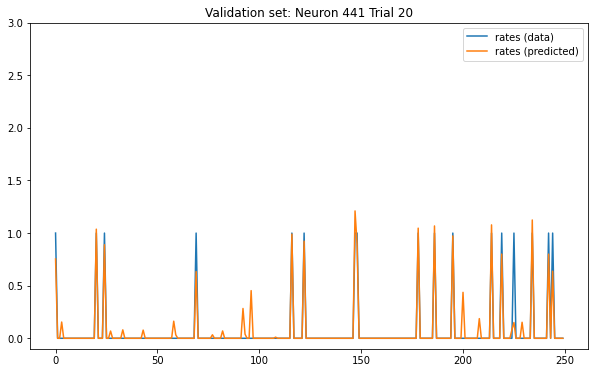

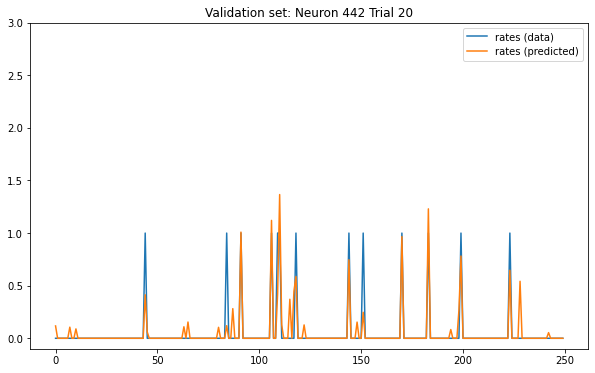

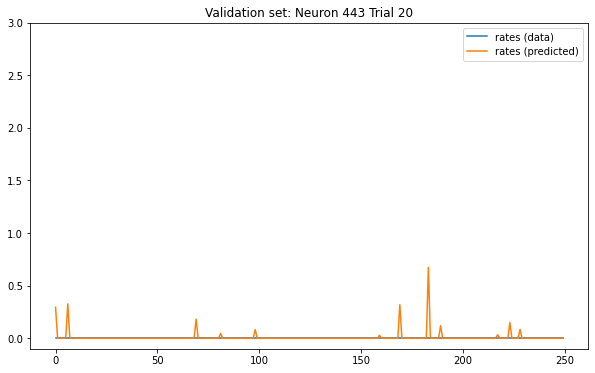

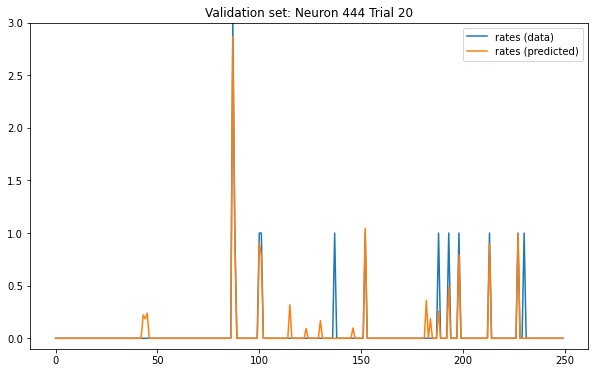

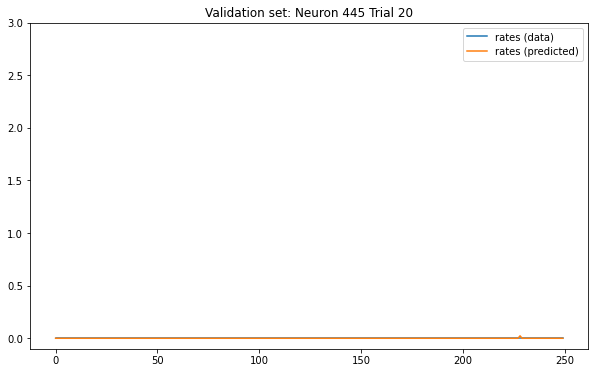

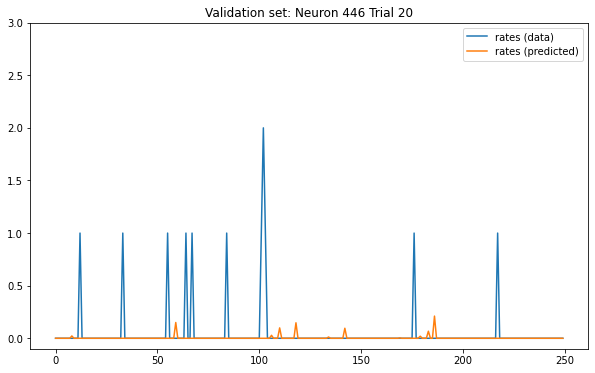

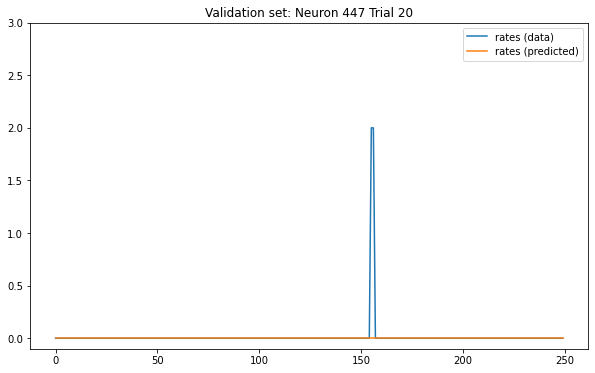

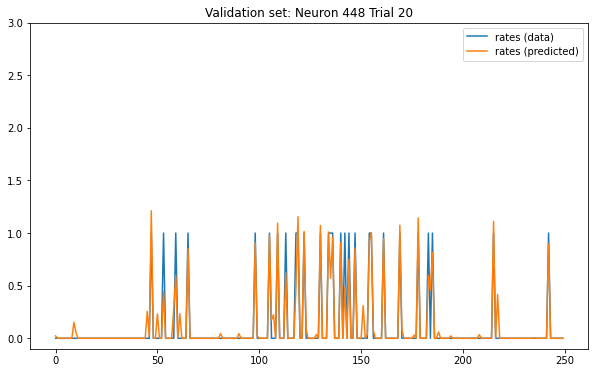

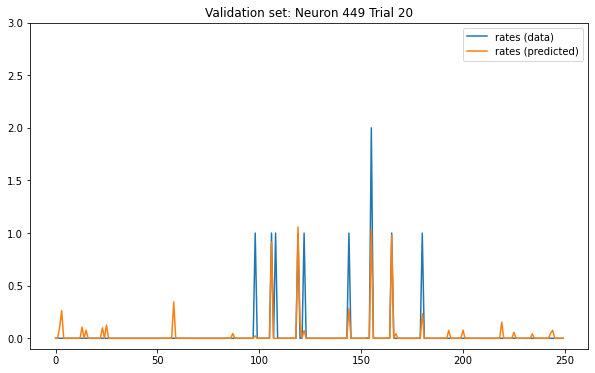

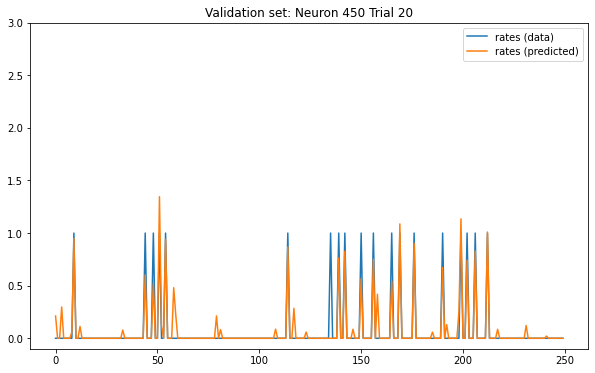

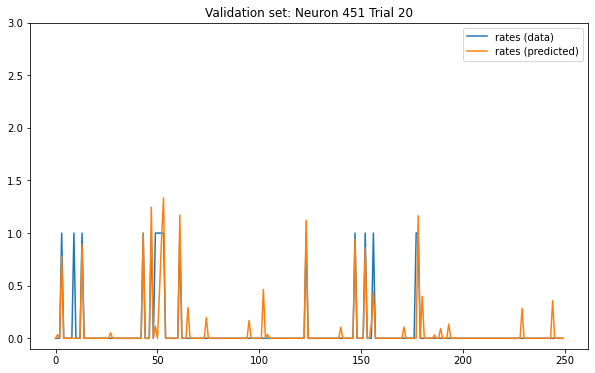

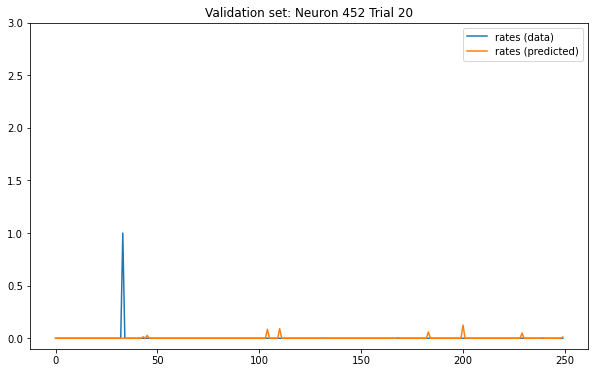

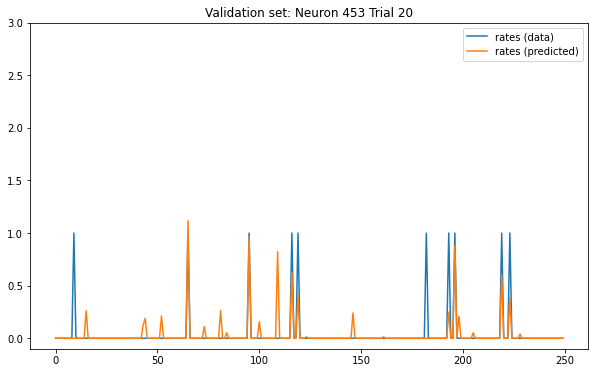

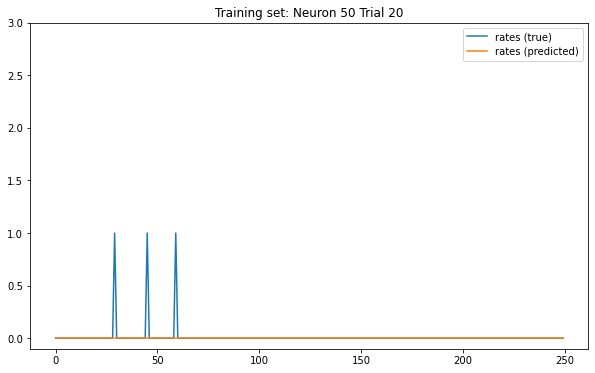

In [ ]:
# visualize the performance of the rnn model
netinput=testData
prd=net(netinput)
rpred = prd.detach().cpu().numpy()
# nn_num = 30
ntrial = 20

for nn_num in range(testData.shape[-1]):
    # Plot for Test Data
    plt.figure(figsize=(10, 6))
    plt.plot(testData[:, ntrial, nn_num], label='rates (data)')
    plt.plot(rpred[:,ntrial, nn_num], label='rates (predicted)')
    plt.legend()
    plt.title(f'Validation set: Neuron {nn_num+200} Trial {ntrial}')
    plt.ylim((-0.1, 3))
    plt.show()

# Plot for Training Data
netinput=trainingData
prd=net(netinput)  
rpred = prd.detach().cpu().numpy()
nn_num = 50
ntrial = 20
plt.figure(figsize=(10, 6))
#plt.plot(fake_spk_rates[:,ntrial, nn_num], label='rates (true)')
plt.plot( trainingData[:, ntrial, nn_num], label='spikes')
plt.plot(rpred[:,ntrial, nn_num], label='rates (predicted)')

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Training set: Neuron {nn_num} Trial {ntrial}')
plt.ylim((-0.1, 3))
plt.show()

In [ ]:
## next: try the model with the real data

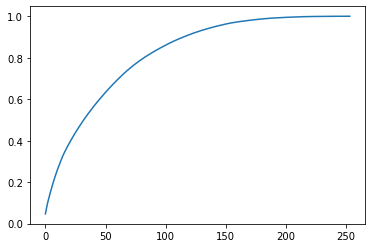

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(trainingData.reshape(-1, trainingData.shape[-1]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
np.concatenate([np.arange(trainingData.shape[-1]).reshape(-1,1), pca.explained_variance_ratio_.cumsum().reshape(-1,1)], -1)

array([[0.00000000e+00, 4.67586737e-02],
       [1.00000000e+00, 7.76707927e-02],
       [2.00000000e+00, 1.03945885e-01],
       [3.00000000e+00, 1.27202081e-01],
       [4.00000000e+00, 1.48668820e-01],
       [5.00000000e+00, 1.69751855e-01],
       [6.00000000e+00, 1.89318315e-01],
       [7.00000000e+00, 2.08204430e-01],
       [8.00000000e+00, 2.26565167e-01],
       [9.00000000e+00, 2.43625840e-01],
       [1.00000000e+01, 2.60038972e-01],
       [1.10000000e+01, 2.75632744e-01],
       [1.20000000e+01, 2.91025862e-01],
       [1.30000000e+01, 3.05729140e-01],
       [1.40000000e+01, 3.20034548e-01],
       [1.50000000e+01, 3.33448148e-01],
       [1.60000000e+01, 3.45333388e-01],
       [1.70000000e+01, 3.56890323e-01],
       [1.80000000e+01, 3.68348665e-01],
       [1.90000000e+01, 3.79206154e-01],
       [2.00000000e+01, 3.89645635e-01],
       [2.10000000e+01, 3.99946395e-01],
       [2.20000000e+01, 4.10081123e-01],
       [2.30000000e+01, 4.20161163e-01],
       [2.400000

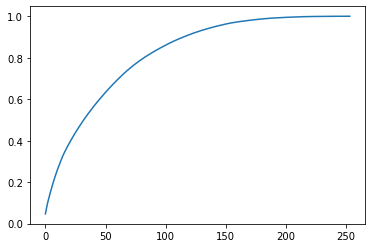

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(trainingData.reshape(-1, trainingData.shape[-1]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [ ]:
np.concatenate([np.arange(trainingData.shape[-1]).reshape(-1,1), pca.explained_variance_ratio_.cumsum().reshape(-1,1)], -1)

array([[0.00000000e+00, 4.67586737e-02],
       [1.00000000e+00, 7.76707927e-02],
       [2.00000000e+00, 1.03945885e-01],
       [3.00000000e+00, 1.27202081e-01],
       [4.00000000e+00, 1.48668820e-01],
       [5.00000000e+00, 1.69751855e-01],
       [6.00000000e+00, 1.89318315e-01],
       [7.00000000e+00, 2.08204430e-01],
       [8.00000000e+00, 2.26565167e-01],
       [9.00000000e+00, 2.43625840e-01],
       [1.00000000e+01, 2.60038972e-01],
       [1.10000000e+01, 2.75632744e-01],
       [1.20000000e+01, 2.91025862e-01],
       [1.30000000e+01, 3.05729140e-01],
       [1.40000000e+01, 3.20034548e-01],
       [1.50000000e+01, 3.33448148e-01],
       [1.60000000e+01, 3.45333388e-01],
       [1.70000000e+01, 3.56890323e-01],
       [1.80000000e+01, 3.68348665e-01],
       [1.90000000e+01, 3.79206154e-01],
       [2.00000000e+01, 3.89645635e-01],
       [2.10000000e+01, 3.99946395e-01],
       [2.20000000e+01, 4.10081123e-01],
       [2.30000000e+01, 4.20161163e-01],
       [2.400000

In [ ]:
n_componenents = 50
testPCA = pca.transform(testData.reshape(-1, testData.shape[-1]))
testReconstructed = pca.inverse_transform(testPCA)[...,:n_componenents].reshape(testData.size(0), testData.size(1), -1)

# plt.plot(testReconstructed[ntrial,nn_num])


In [ ]:
# nn.MSELoss(torch.tensor(testReconstructed), testData)

In [ ]:
# # prepare for training

# # file = open("Cori_MOs.pkl",'rb')
# file = open("Cori_Post.pkl",'rb')
# spk = pickle.load(file)

# NT=spk.shape[0]
# ntrials=spk.shape[1]
# NN=spk.shape[2]
# ncomp=10

# trainingData = torch.from_numpy(spk[:, :ntrials*4//5, :]).to(device).float()
# testData = torch.from_numpy(spk[:, ntrials*4//5:, :]).to(device).float()
